# Seurat - Guided Clustering Tutorial of 2,700 PBMCs

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/imperial-genomics-facility/seurat-notebook-image/master?urlpath=lab/examples/seurat_pbmc_v0.0.1.ipynb)

This notebook was created using the codes and documentations from the following Seurat tutorial: [Seurat - Guided Clustering Tutorial](https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html). This notebook provides a basic overview of Seurat including the the following:

* QC and pre-processing
* Dimension reduction
* Clustering
* Differential expression

## Downloading data from 10X Genomics

In [1]:
system("cd /tmp;\
        wget -q http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz;\
        tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz")

## Setup the Seurat Object

In [2]:
library(dplyr)
library(Seurat)
library(patchwork)

# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "/tmp/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
"package 'dplyr' was built under R version 3.6.1"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'Seurat' was built under R version 3.6.3"
Warning message:
"package 'patchwork' was built under R version 3.6.1"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

In [3]:
# Lets examine a few genes in the first thirty cells
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]

   [[ suppressing 30 column names 'AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1' ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

In [4]:
dense.size <- object.size(as.matrix(pbmc.data))
dense.size

709591472 bytes

In [5]:
sparse.size <- object.size(pbmc.data)
sparse.size

29905192 bytes

In [6]:
dense.size/sparse.size

23.7 bytes

## QC and selecting cells for further analysis

In [7]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [8]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898


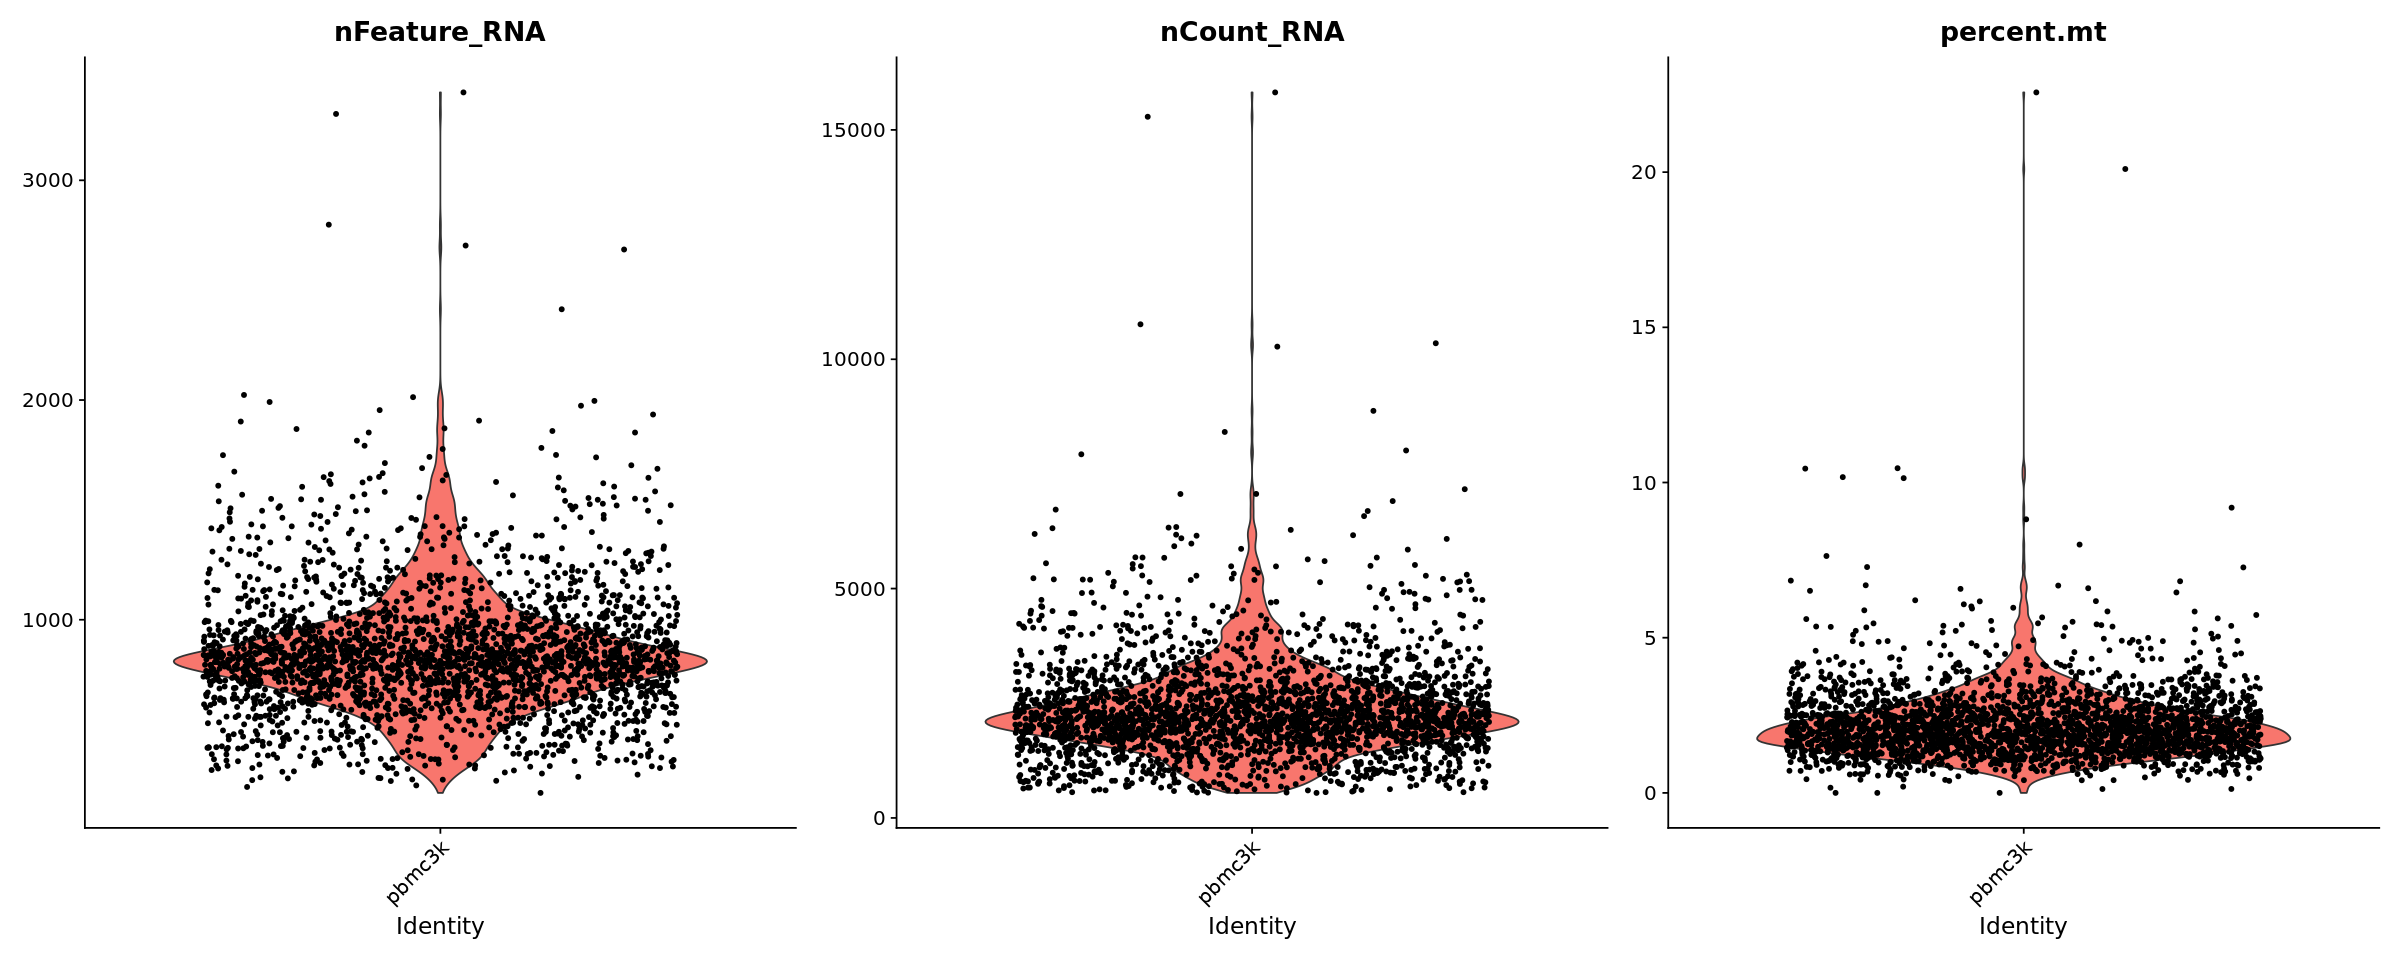

In [9]:
# Visualize QC metrics as a violin plot
options(repr.plot.width=20, repr.plot.height=8)
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

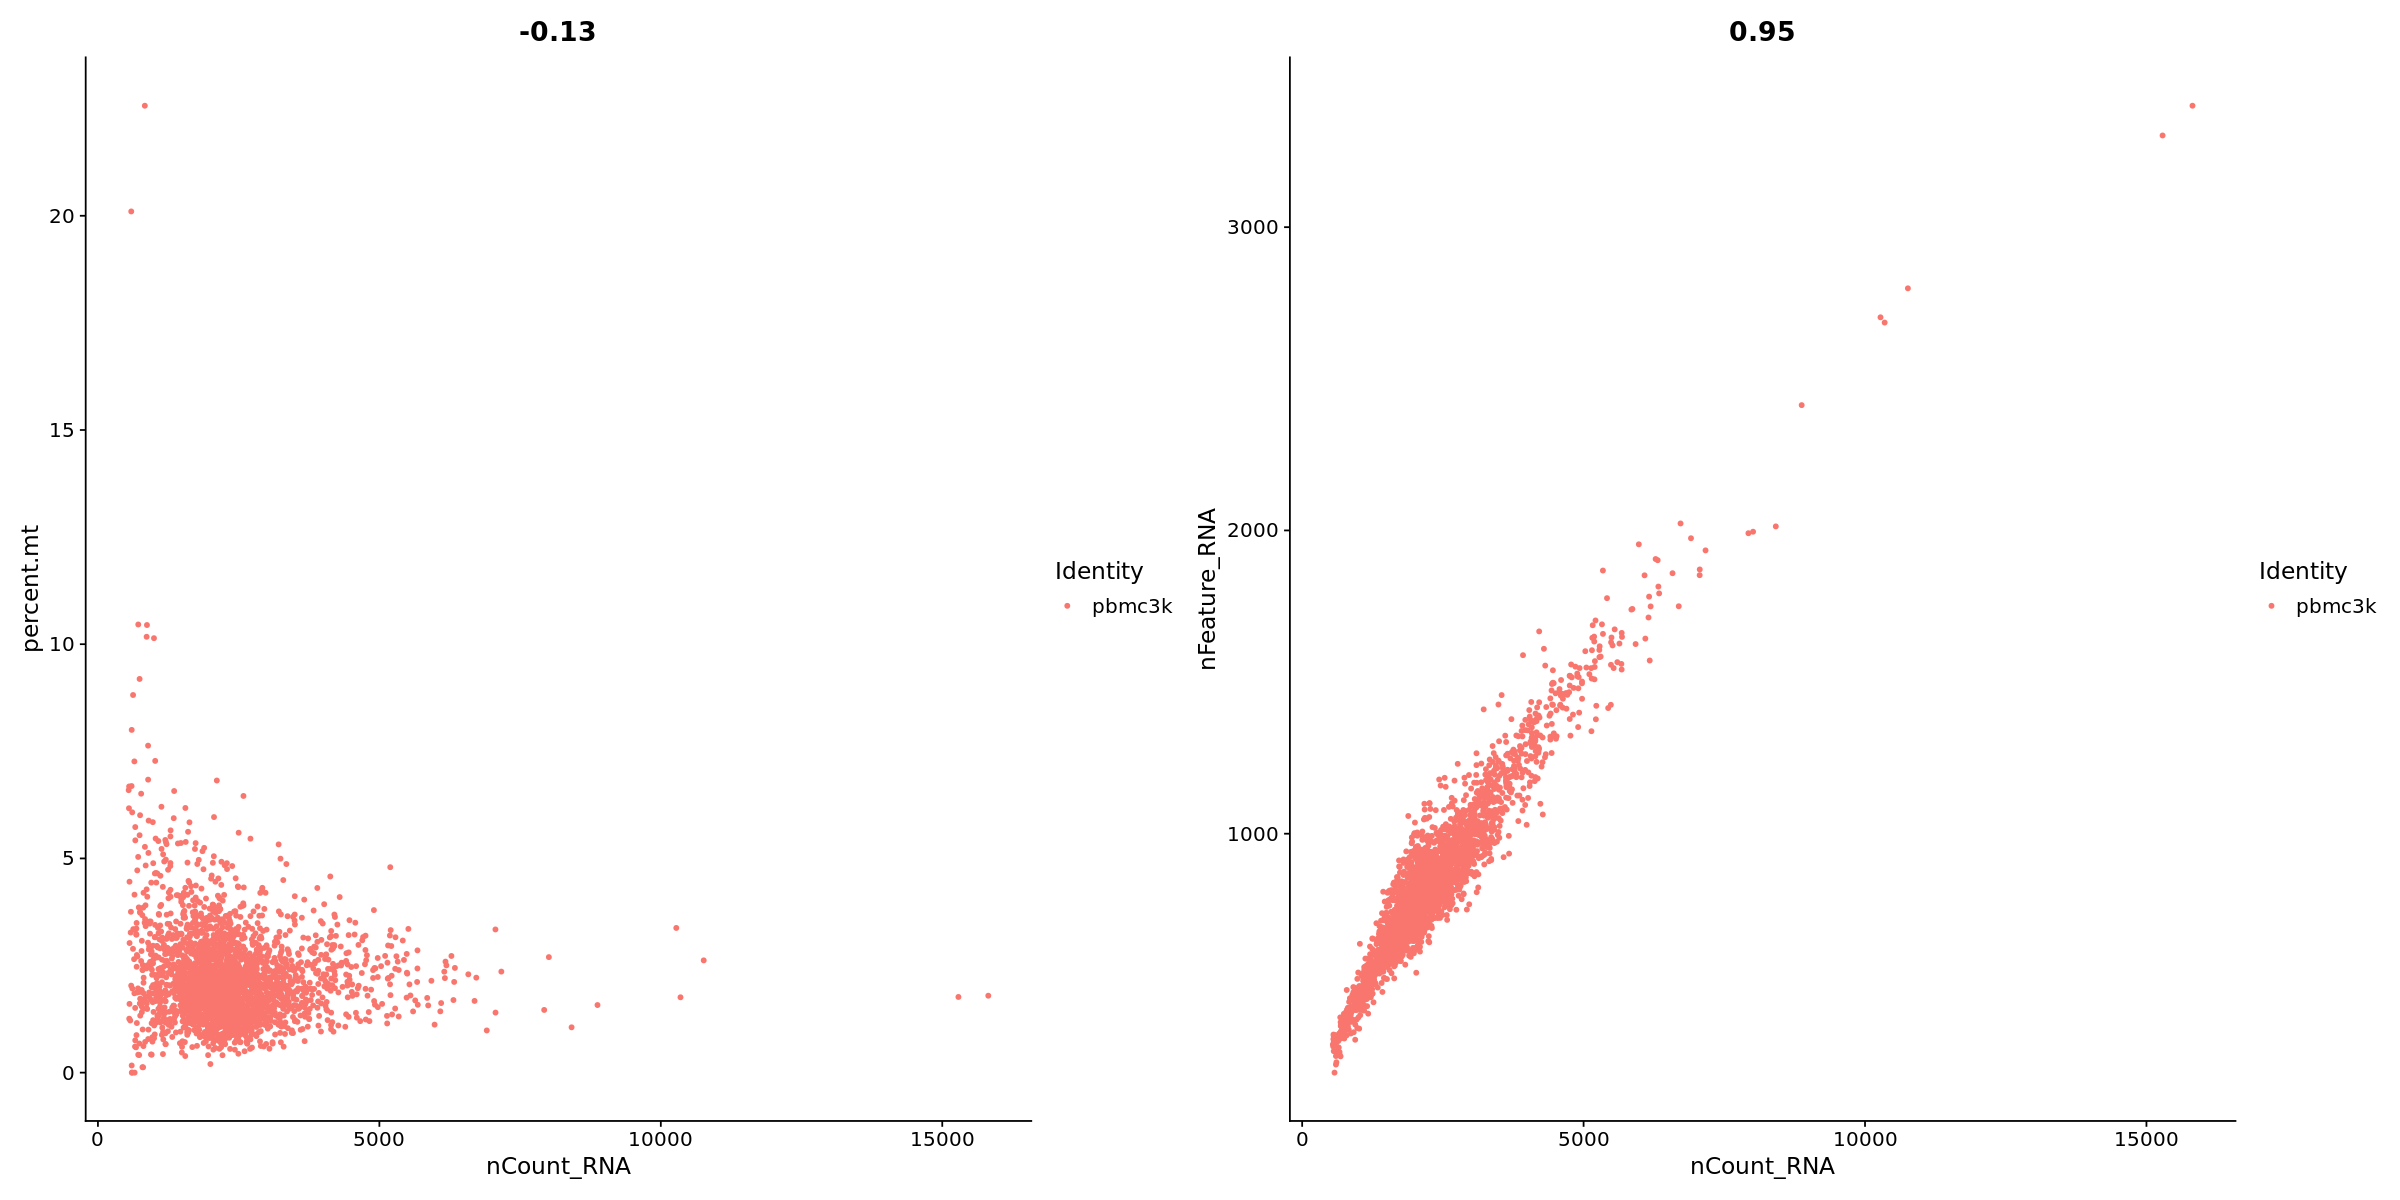

In [10]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
options(repr.plot.width=20, repr.plot.height=10)
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [11]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

## Normalizing the data

In [12]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

In [13]:
pbmc <- NormalizeData(pbmc)

## Identification of highly variable features (feature selection)

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"


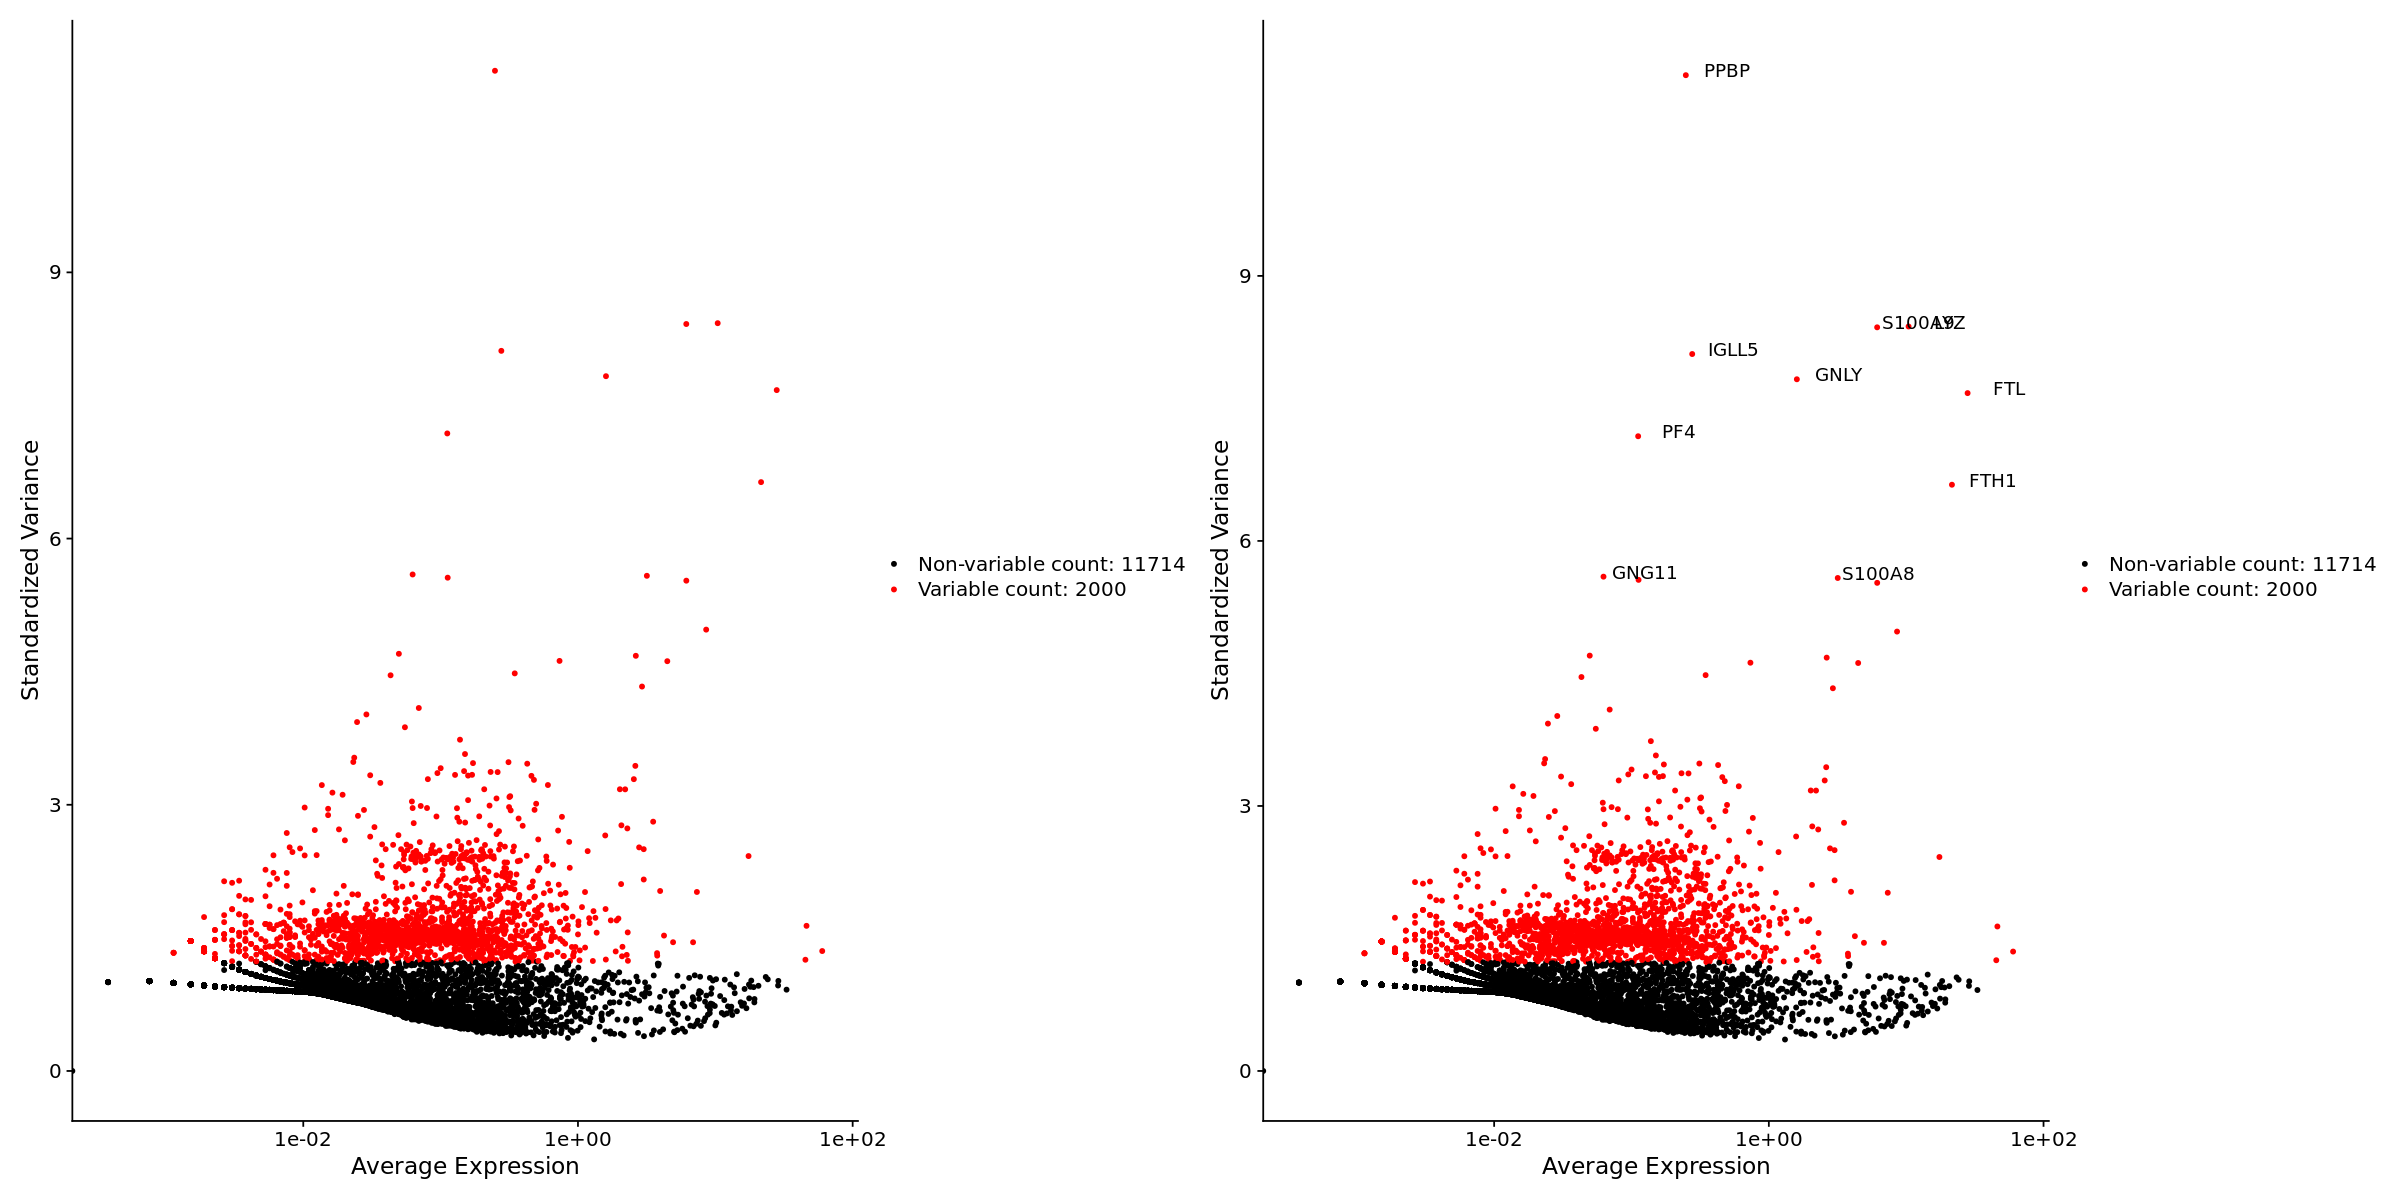

In [14]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = FALSE)
plot1 + plot2

## Scaling the data

In [15]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



## Perform linear dimensional reduction

In [16]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

In [17]:
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


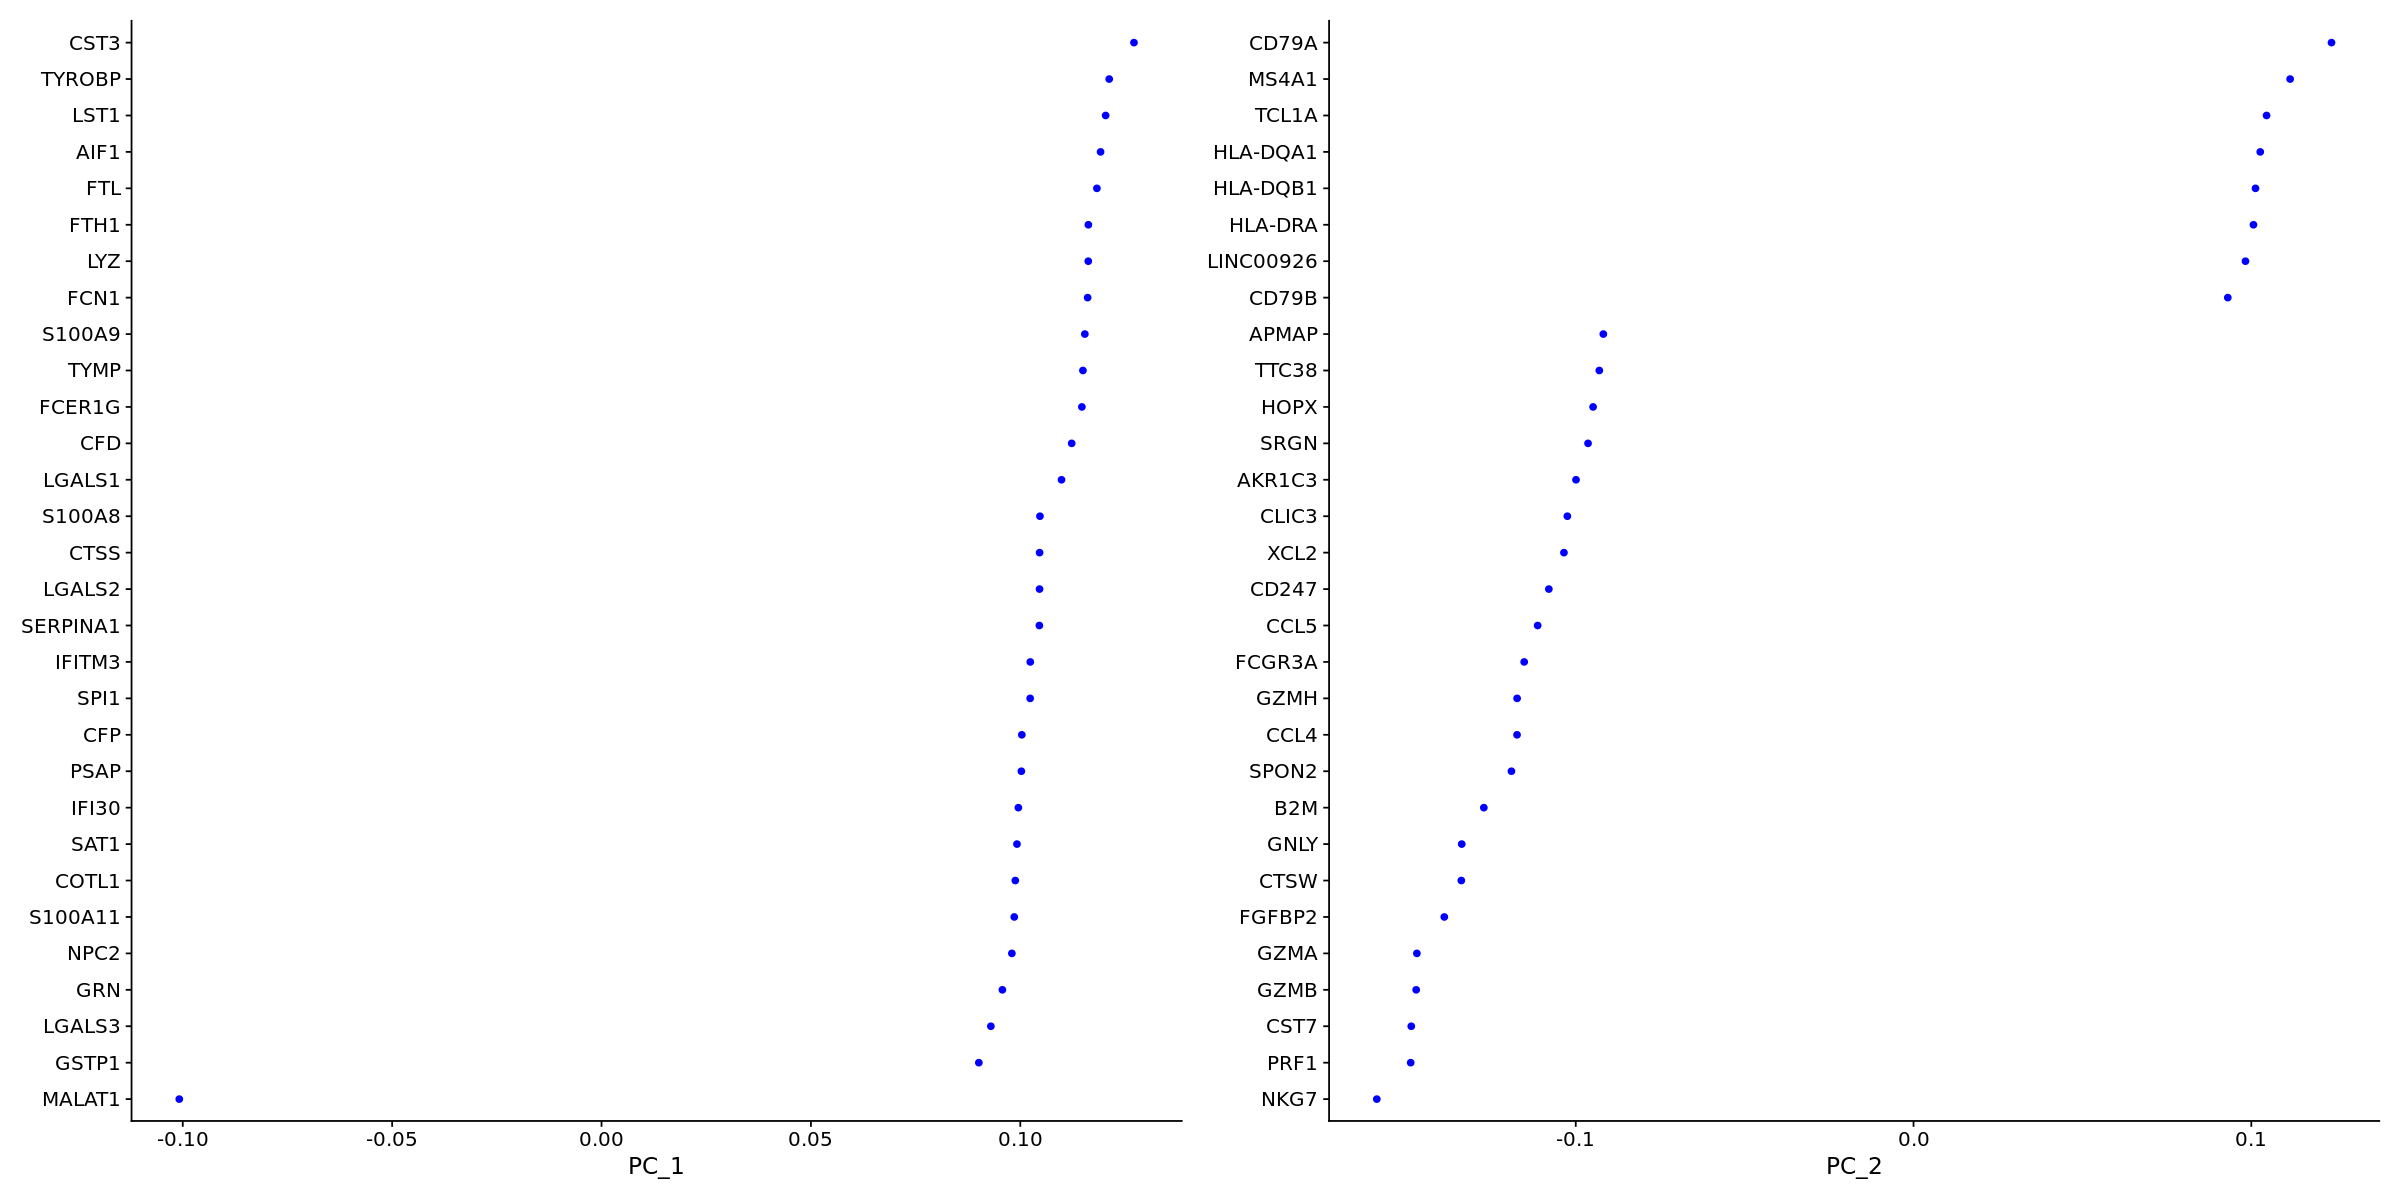

In [18]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

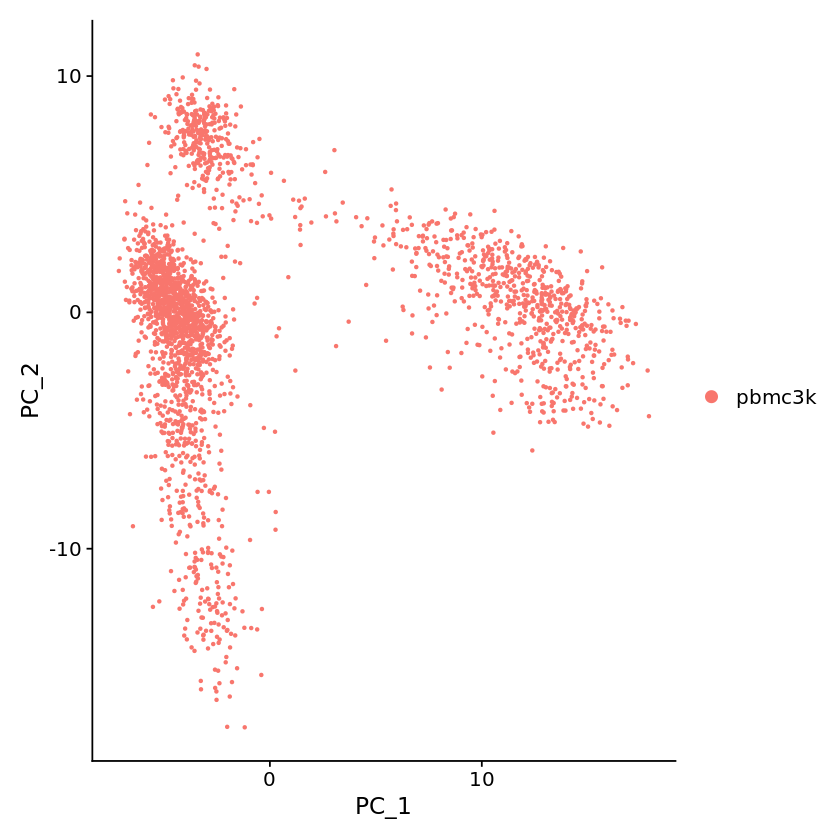

In [19]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(pbmc, reduction = "pca")

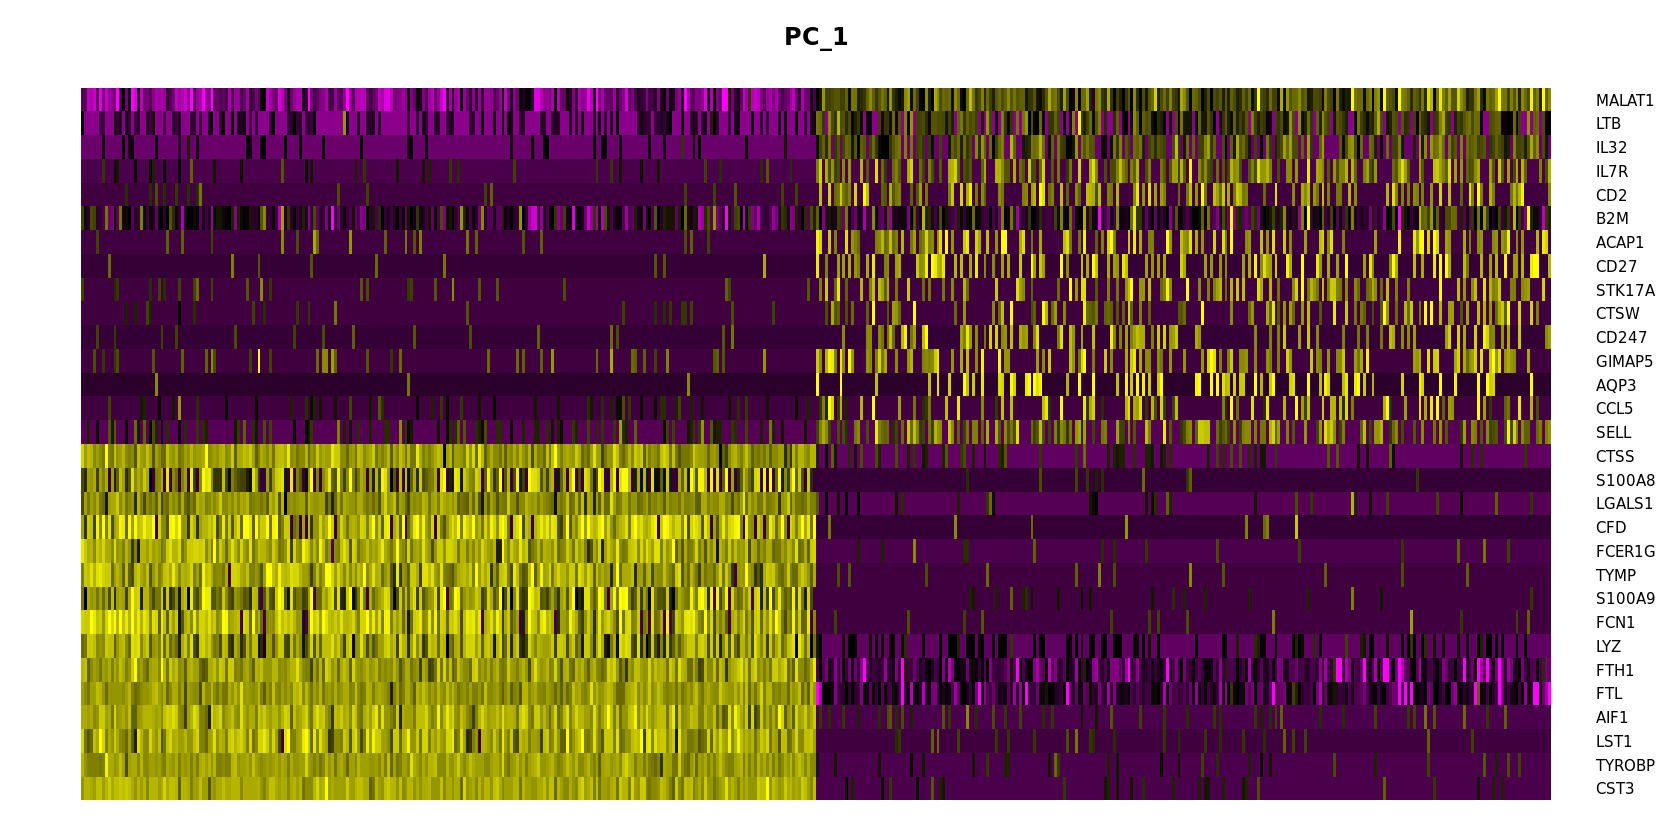

In [20]:
options(repr.plot.width=14, repr.plot.height=7)
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

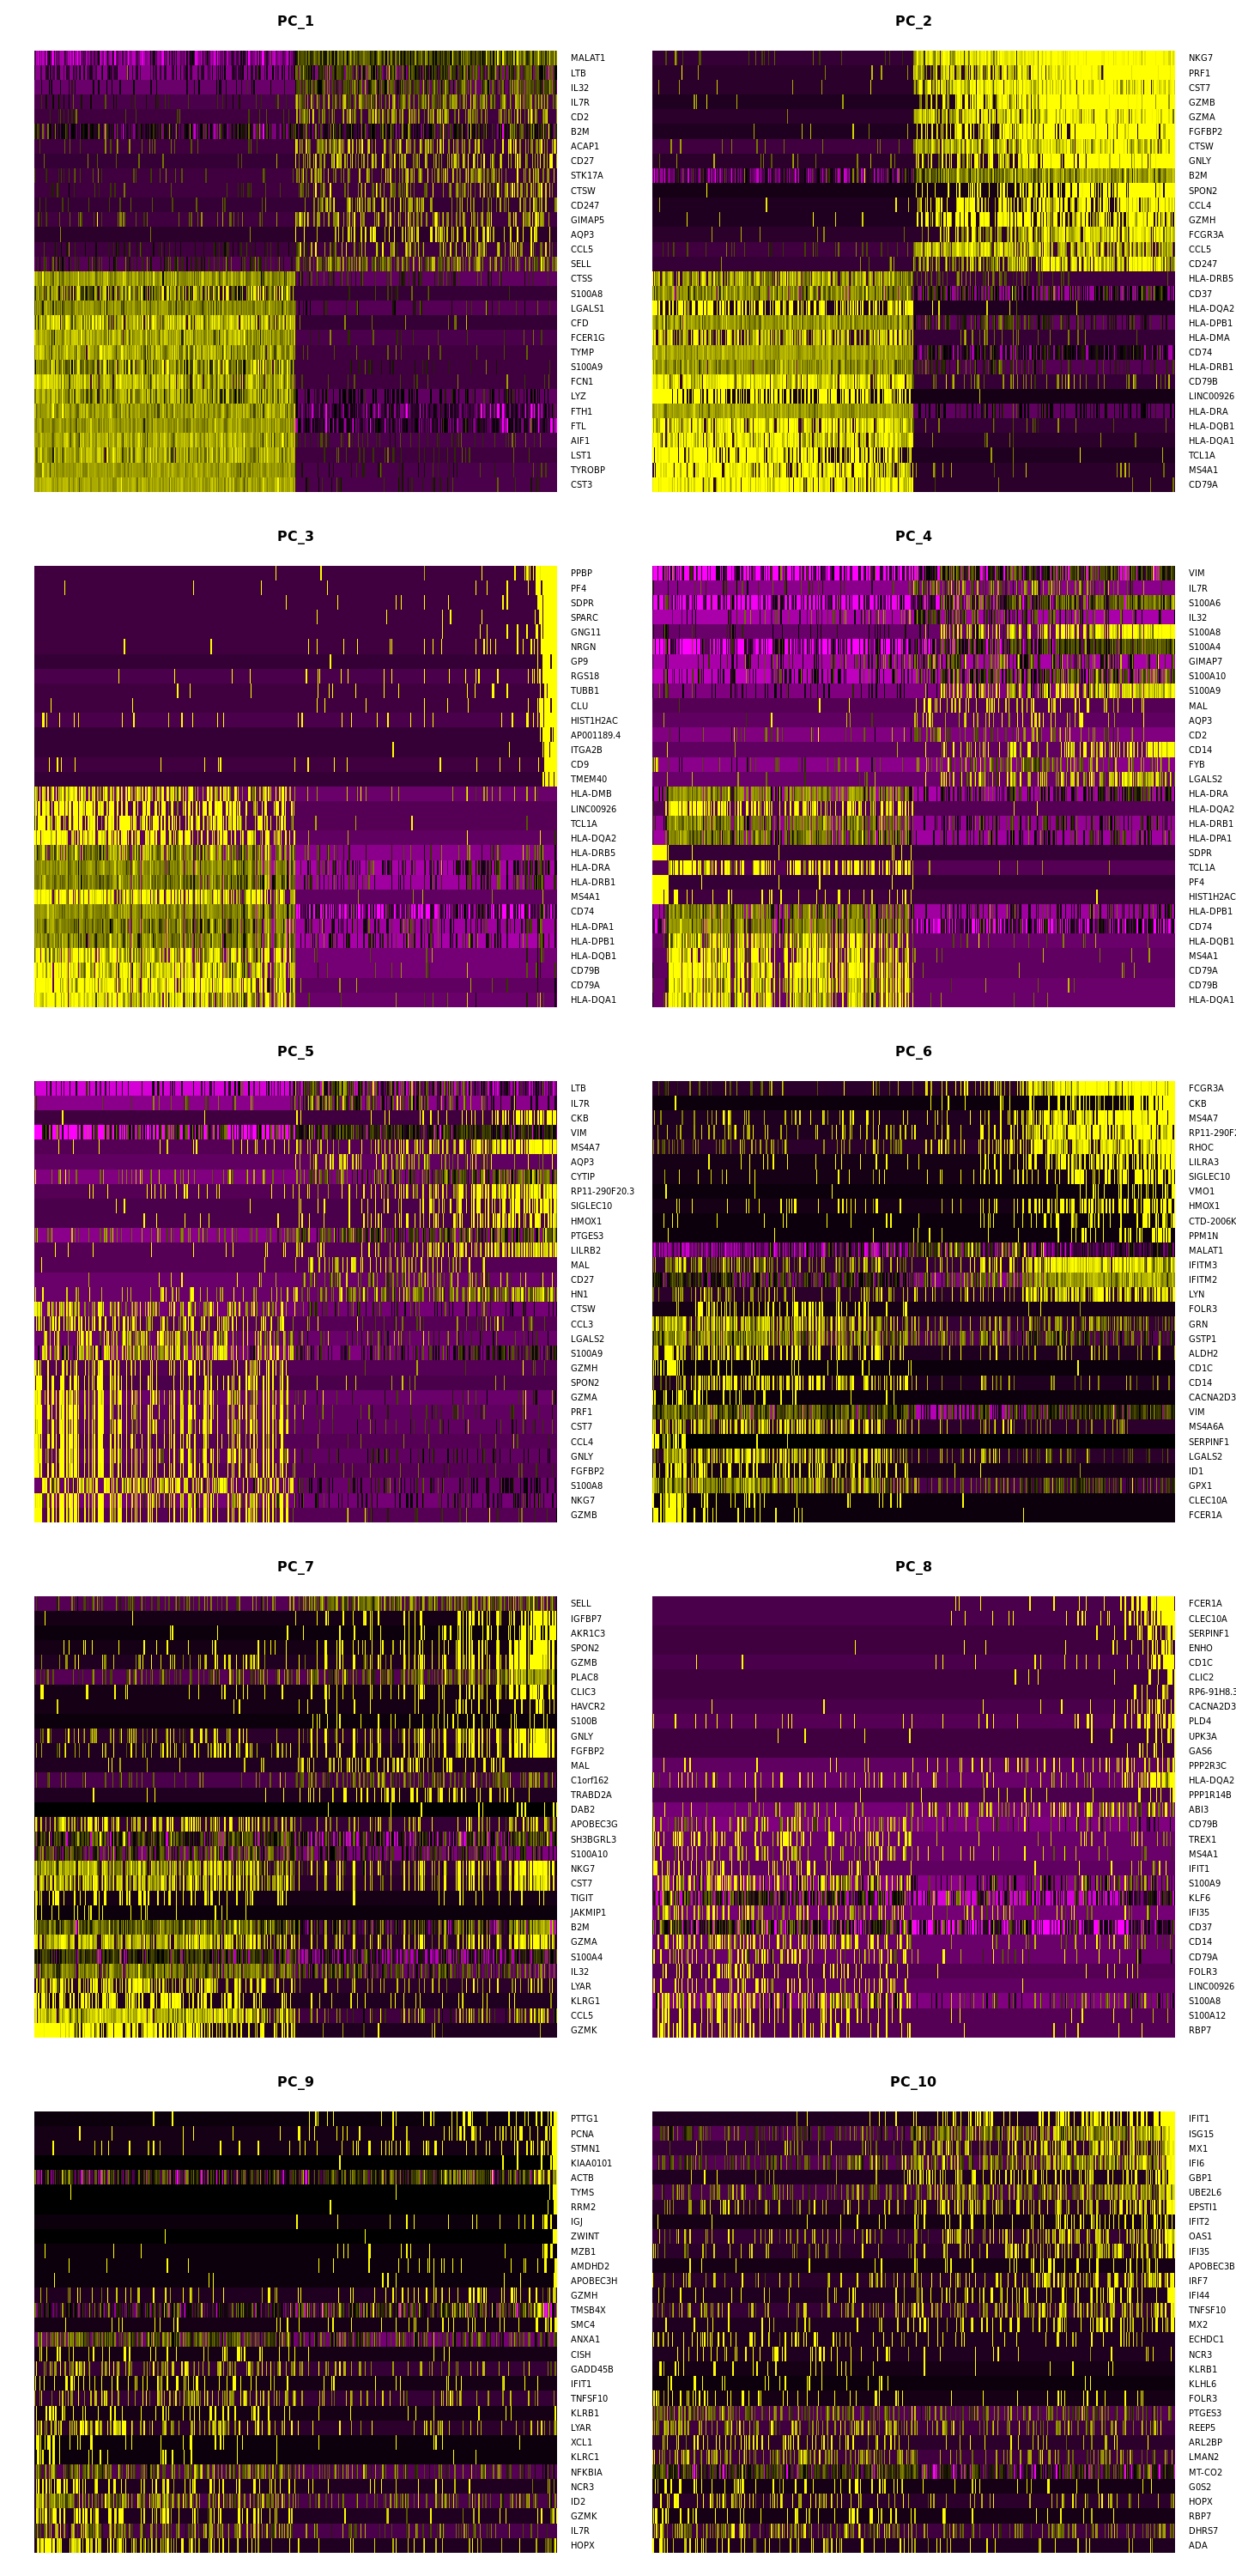

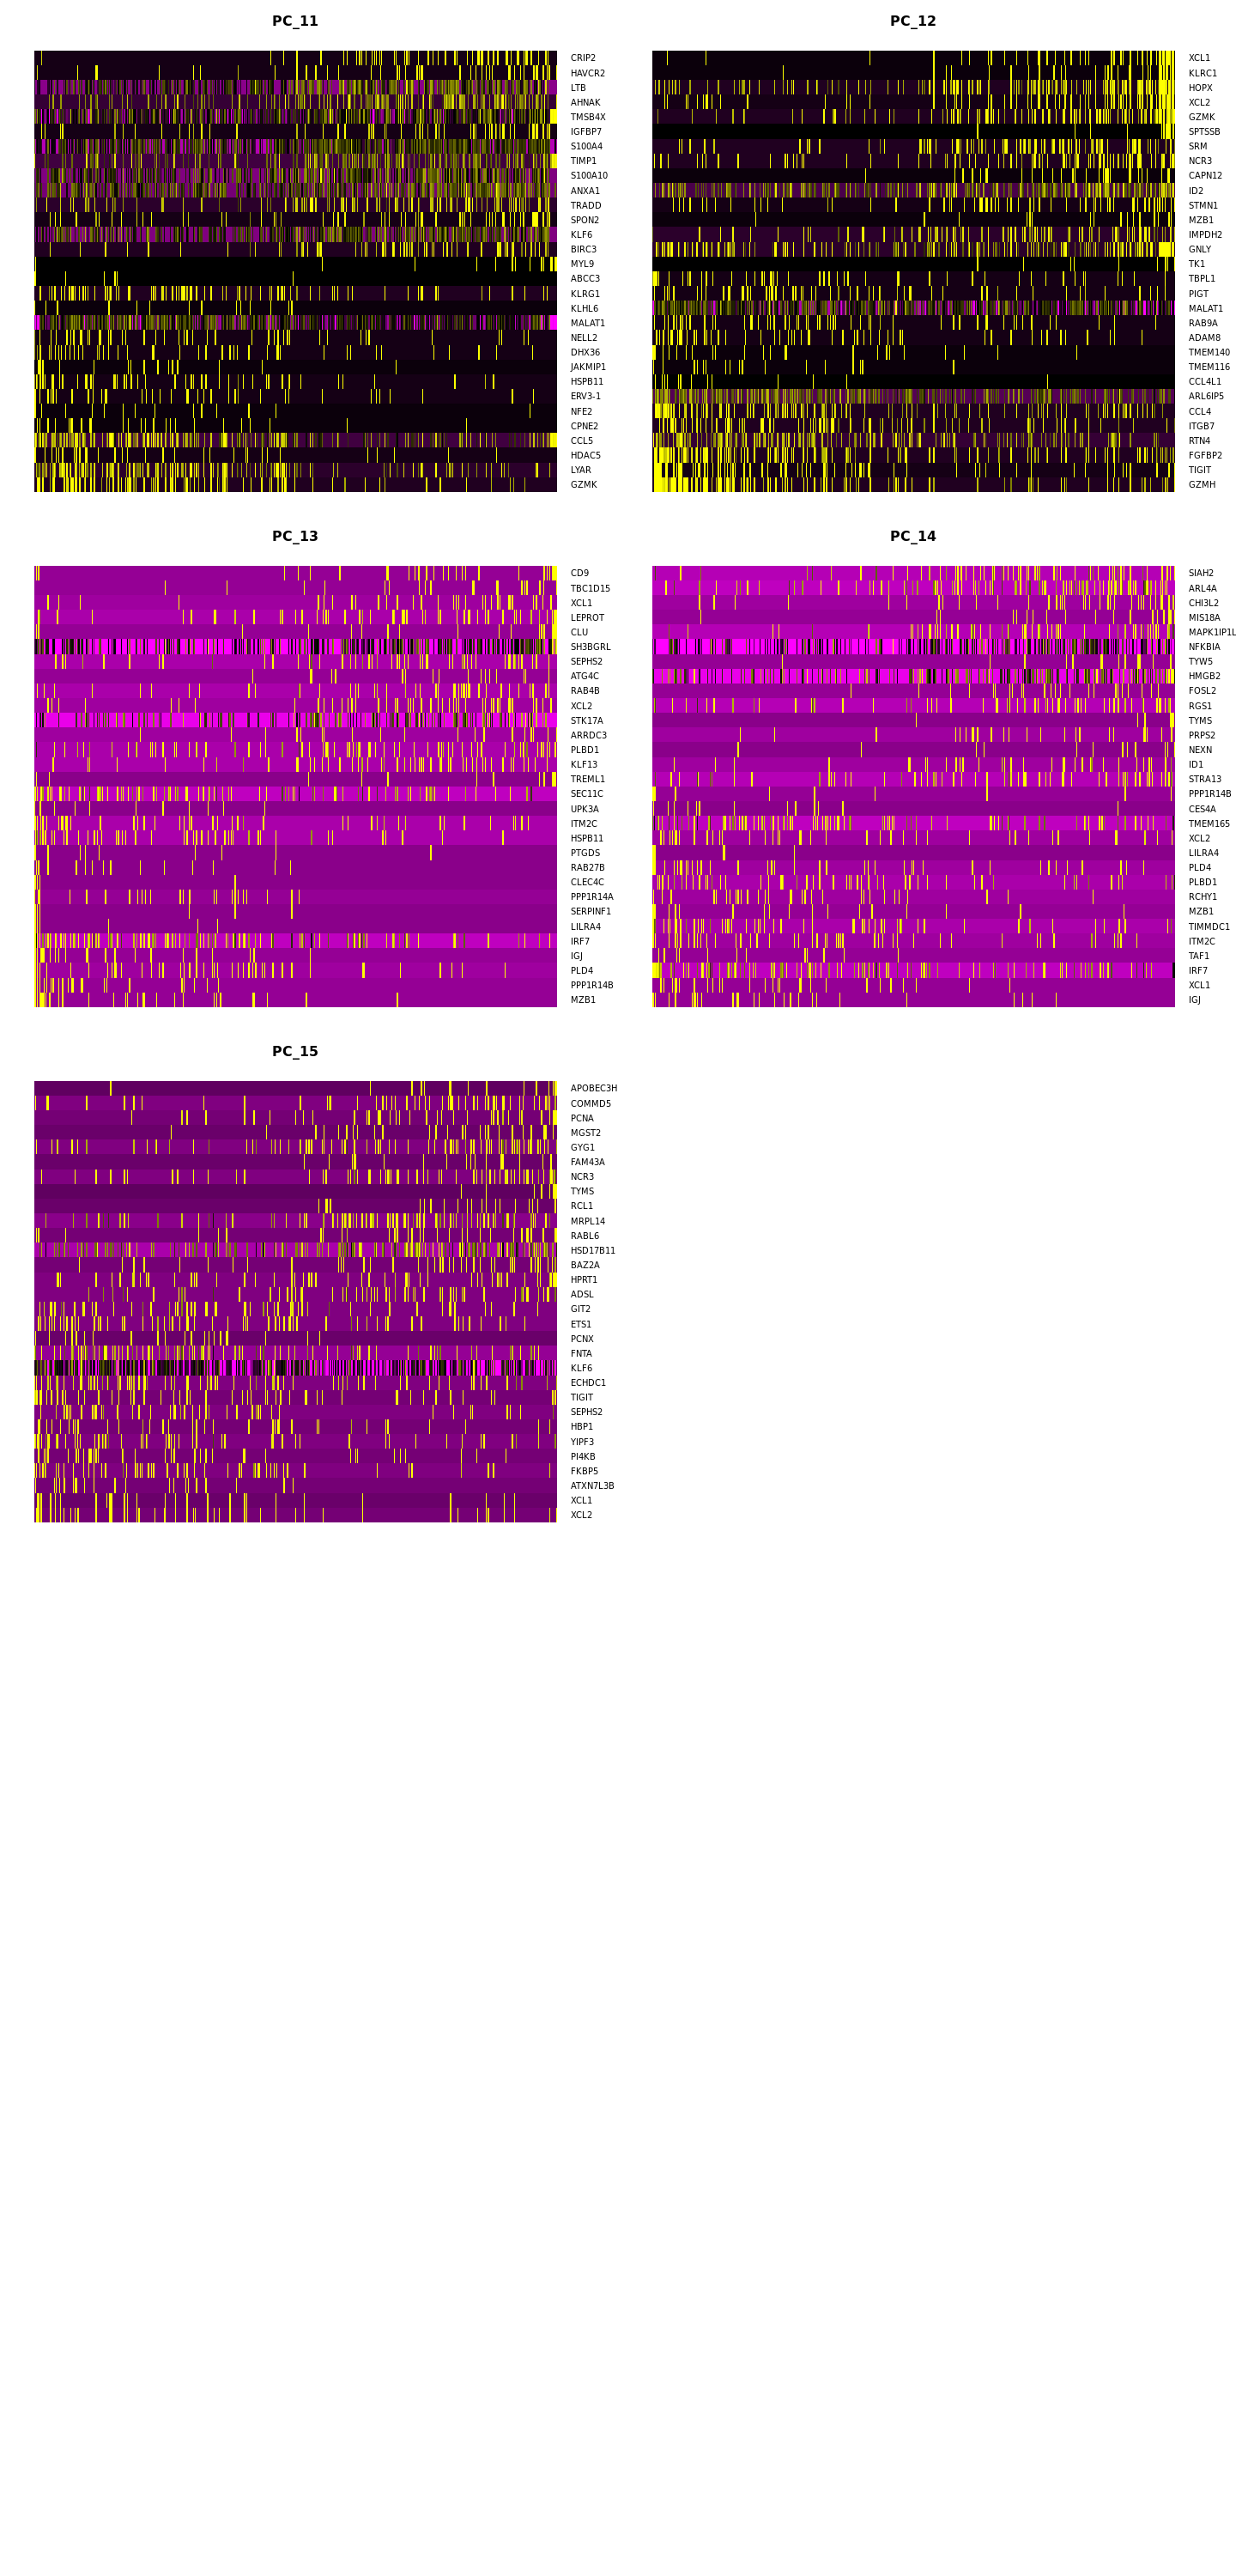

In [21]:
options(repr.plot.width=12, repr.plot.height=25)
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE,ncol = 2)

## Determine the ‘dimensionality’ of the dataset

In [22]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

Warning message:
"Removed 23504 rows containing missing values (geom_point)."


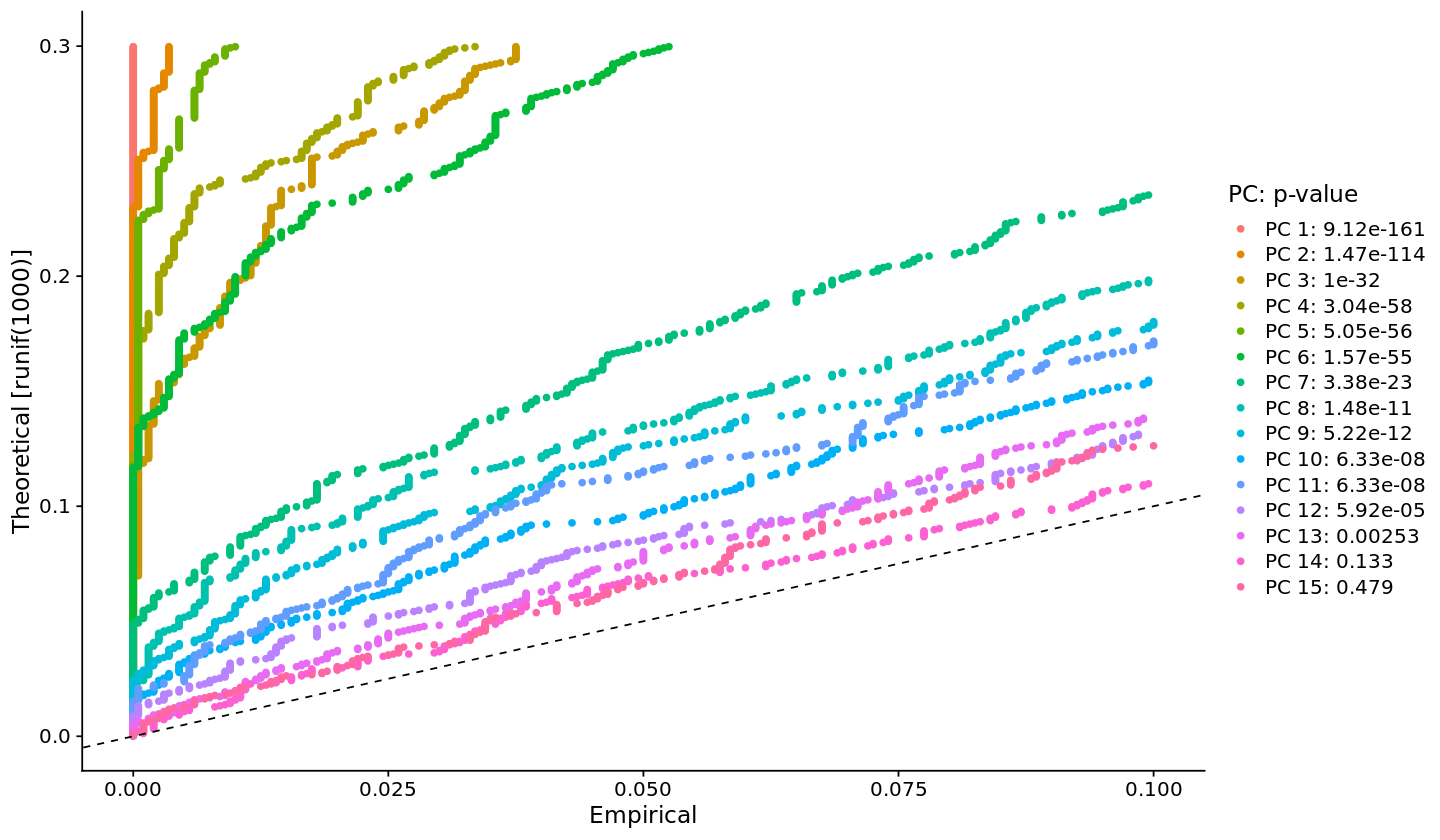

In [23]:
options(repr.plot.width=12, repr.plot.height=7)
JackStrawPlot(pbmc, dims = 1:15)

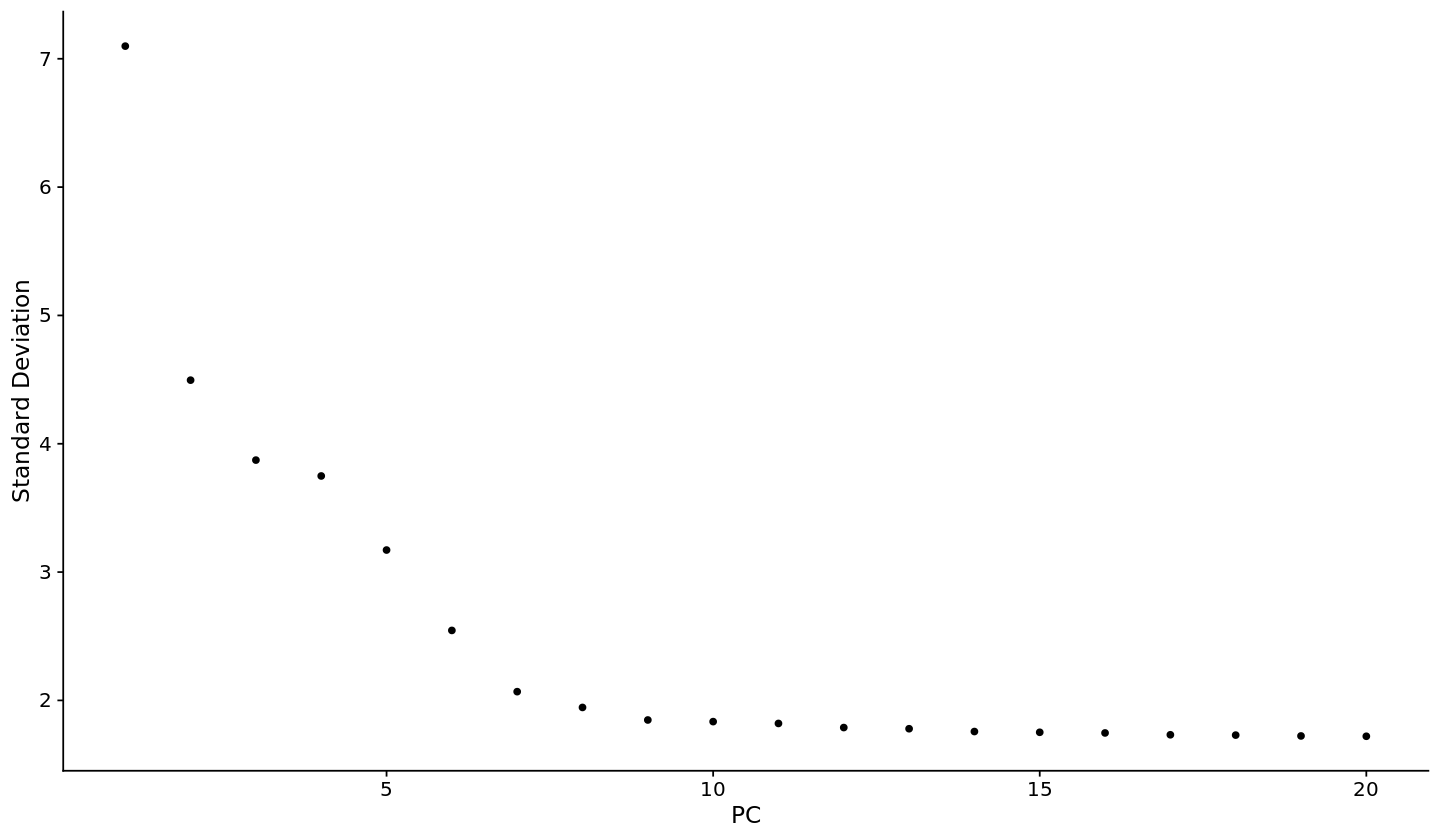

In [24]:
options(repr.plot.width=12, repr.plot.height=7)
ElbowPlot(pbmc)

## Cluster the cells

In [25]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 96033

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8720
Number of communities: 9
Elapsed time: 0 seconds


In [26]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               1                3                1                2 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

## Run non-linear dimensional reduction (UMAP/tSNE)

In [27]:
# If you haven't installed UMAP, you can do so via reticulate::py_install(packages =
# 'umap-learn')
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
21:15:29 UMAP embedding parameters a = 0.9922 b = 1.112

21:15:29 Read 2638 rows and found 10 numeric columns

21:15:29 Using Annoy for neighbor search, n_neighbors = 30

21:15:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:15:29 Writing NN index file to temp file /home/vmuser/.tmp/RtmpVM9CnA/file2e84a1af735

21:15:29 Searching Annoy index using 1 thread, search_k = 3000

21:15:30 Annoy recall = 100%

21:15:31 Commencing smooth kNN distance calibration using 1 thread

21:15:31 Ini

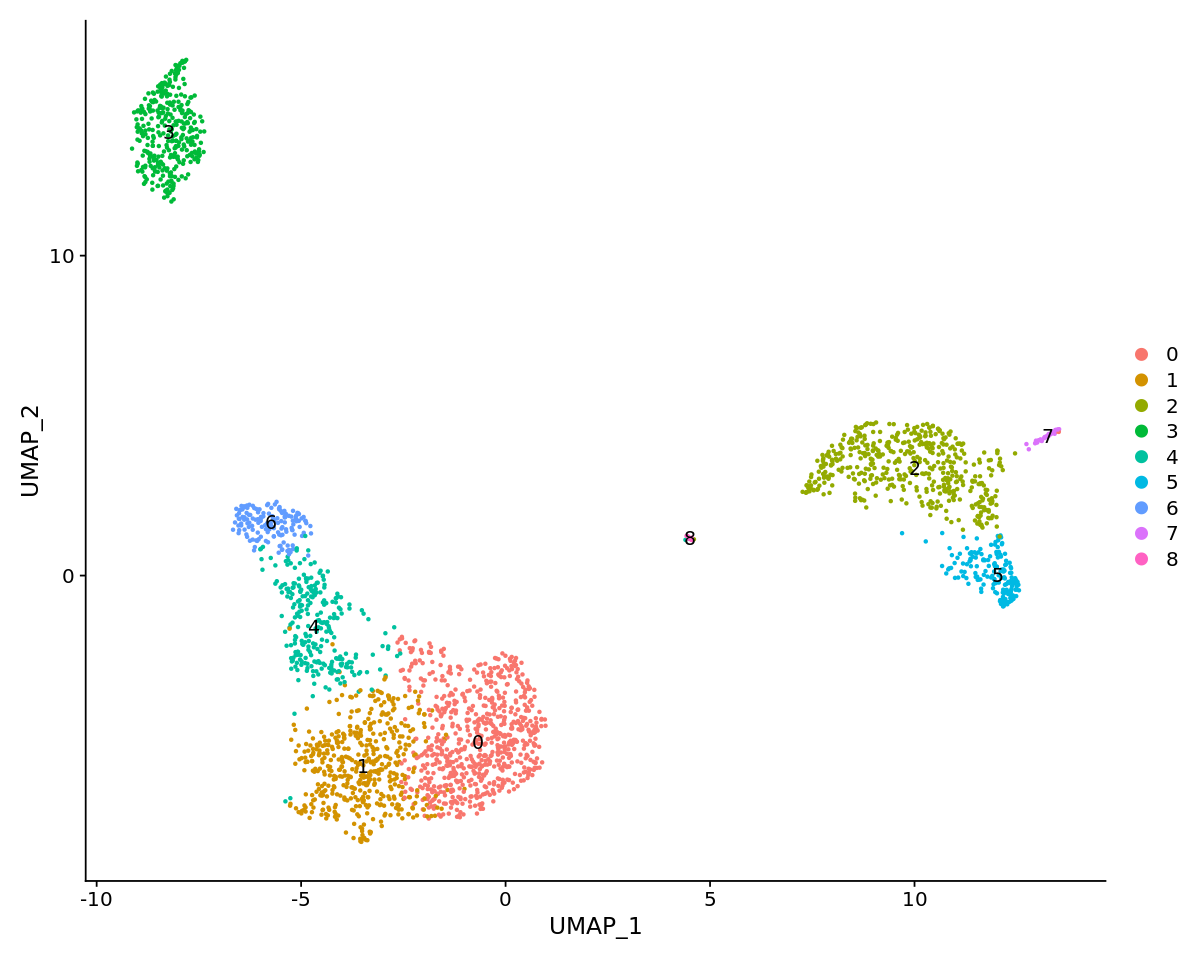

In [28]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(pbmc, reduction = "umap",label=TRUE)

## Finding differentially expressed features (cluster biomarkers)

In [29]:
# find all markers of cluster 1
cluster1.markers <- FindMarkers(pbmc, ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 5)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,1.894810e-92,0.8373872,0.948,0.464,2.598542e-88
LTB,7.953303e-89,0.8921170,0.981,0.642,1.090716e-84
CD3D,1.655937e-70,0.6436286,0.919,0.431,2.270951e-66
IL7R,3.688893e-68,0.8147082,0.747,0.325,5.058947e-64
LDHB,2.292819e-67,0.6253110,0.950,0.613,3.144372e-63


In [30]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,7.583625e-209,2.963144,0.975,0.037,1.040018e-204
IFITM3,2.500844e-199,2.698187,0.975,0.046,3.429657e-195
CFD,1.763722e-195,2.362381,0.938,0.037,2.418768e-191
CD68,4.612171e-192,2.087366,0.926,0.036,6.325132e-188
RP11-290F20.3,1.846215e-188,1.886288,0.840,0.016,2.531900e-184


In [31]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25);
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC);

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.963031e-107,0.7300635,0.901,0.594,2.692101e-103,0,LDHB
1.606796e-82,0.9219135,0.436,0.110,2.203560e-78,0,CCR7
7.953303e-89,0.8921170,0.981,0.642,1.090716e-84,1,LTB
1.851623e-60,0.8586034,0.422,0.110,2.539316e-56,1,AQP3
0.000000e+00,3.8608733,0.996,0.215,0.000000e+00,2,S100A9
0.000000e+00,3.7966403,0.975,0.121,0.000000e+00,2,S100A8
0.000000e+00,2.9875833,0.936,0.041,0.000000e+00,3,CD79A
9.481783e-271,2.4894932,0.622,0.022,1.300332e-266,3,TCL1A
2.958181e-189,2.1220555,0.985,0.240,4.056849e-185,4,CCL5


In [32]:
cluster1.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

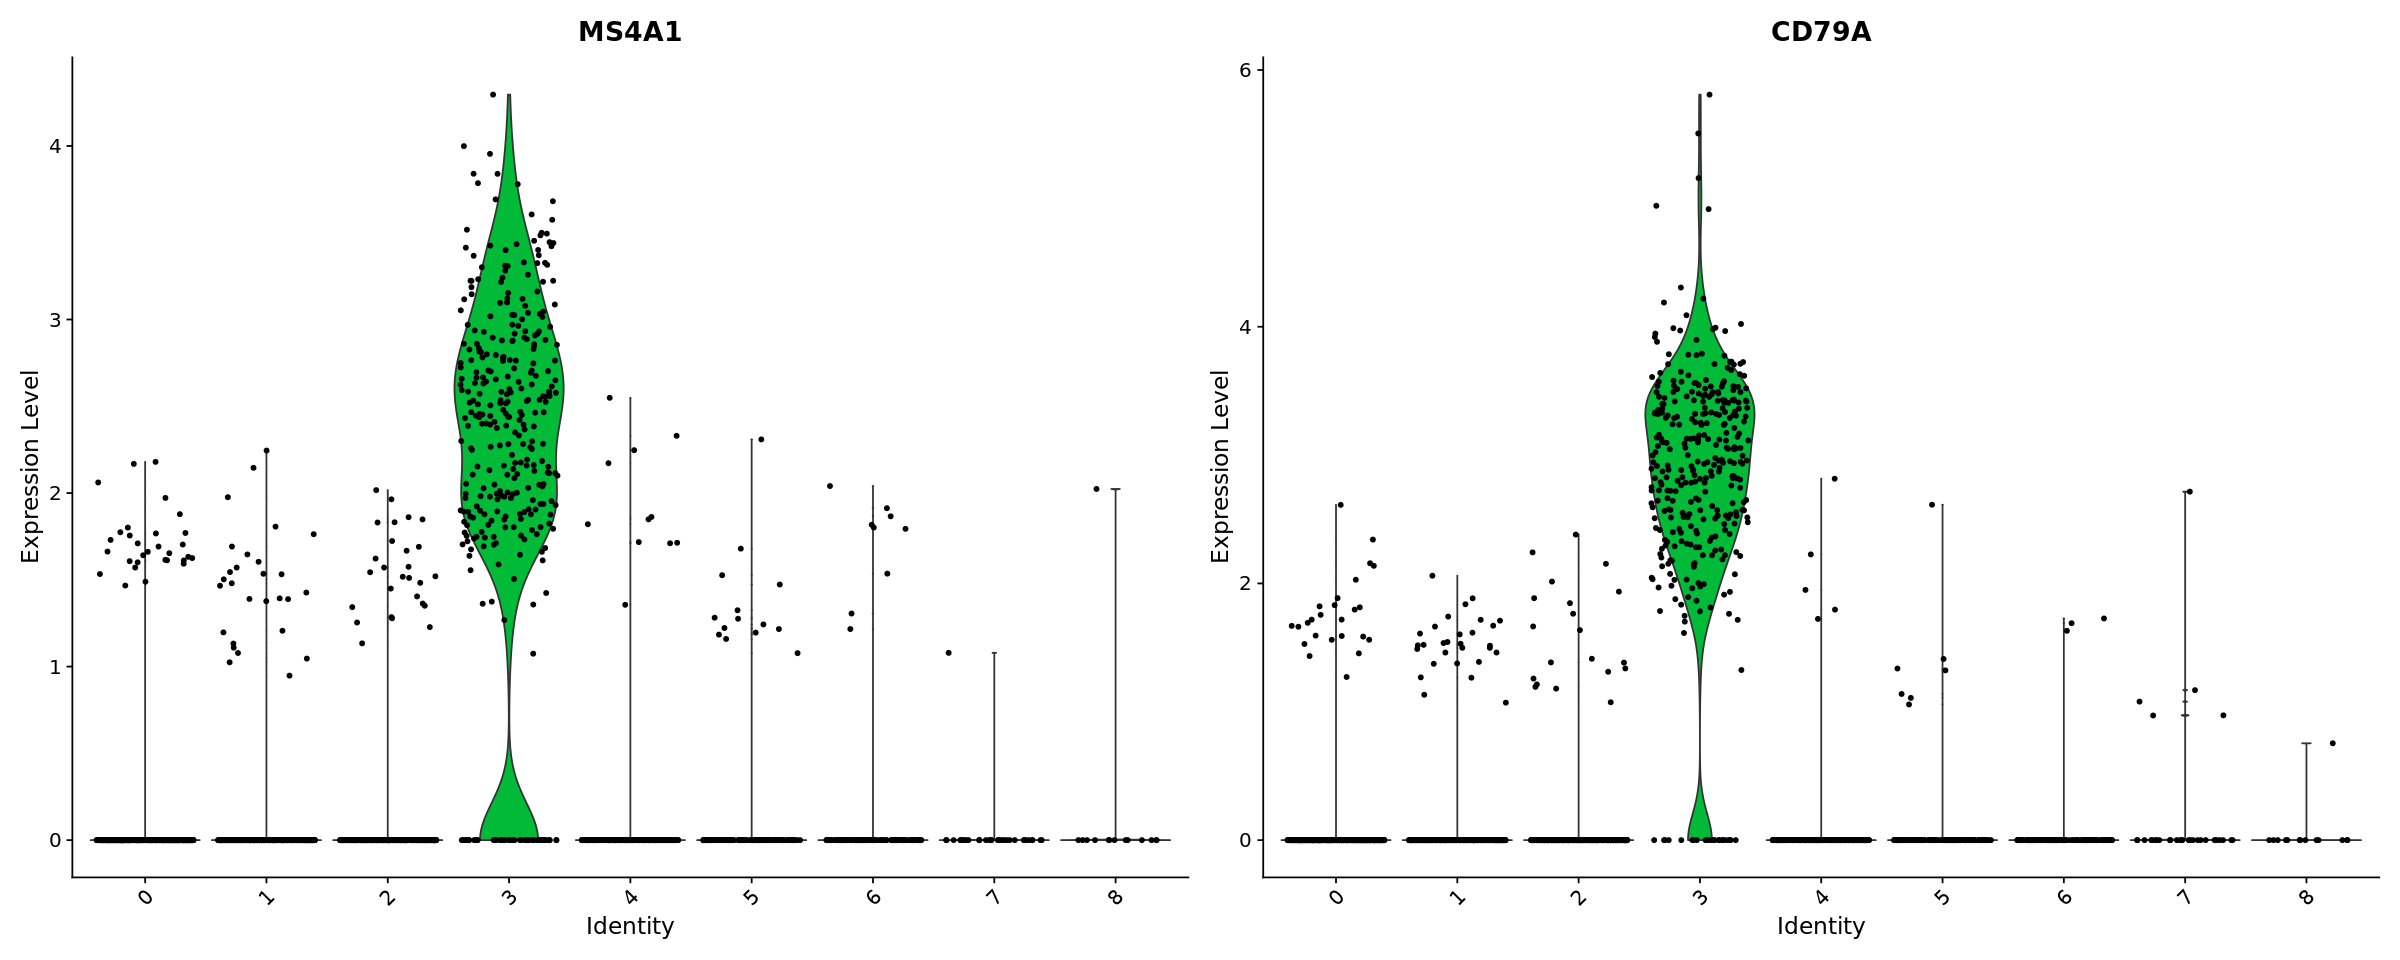

In [33]:
options(repr.plot.width=20, repr.plot.height=8)
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

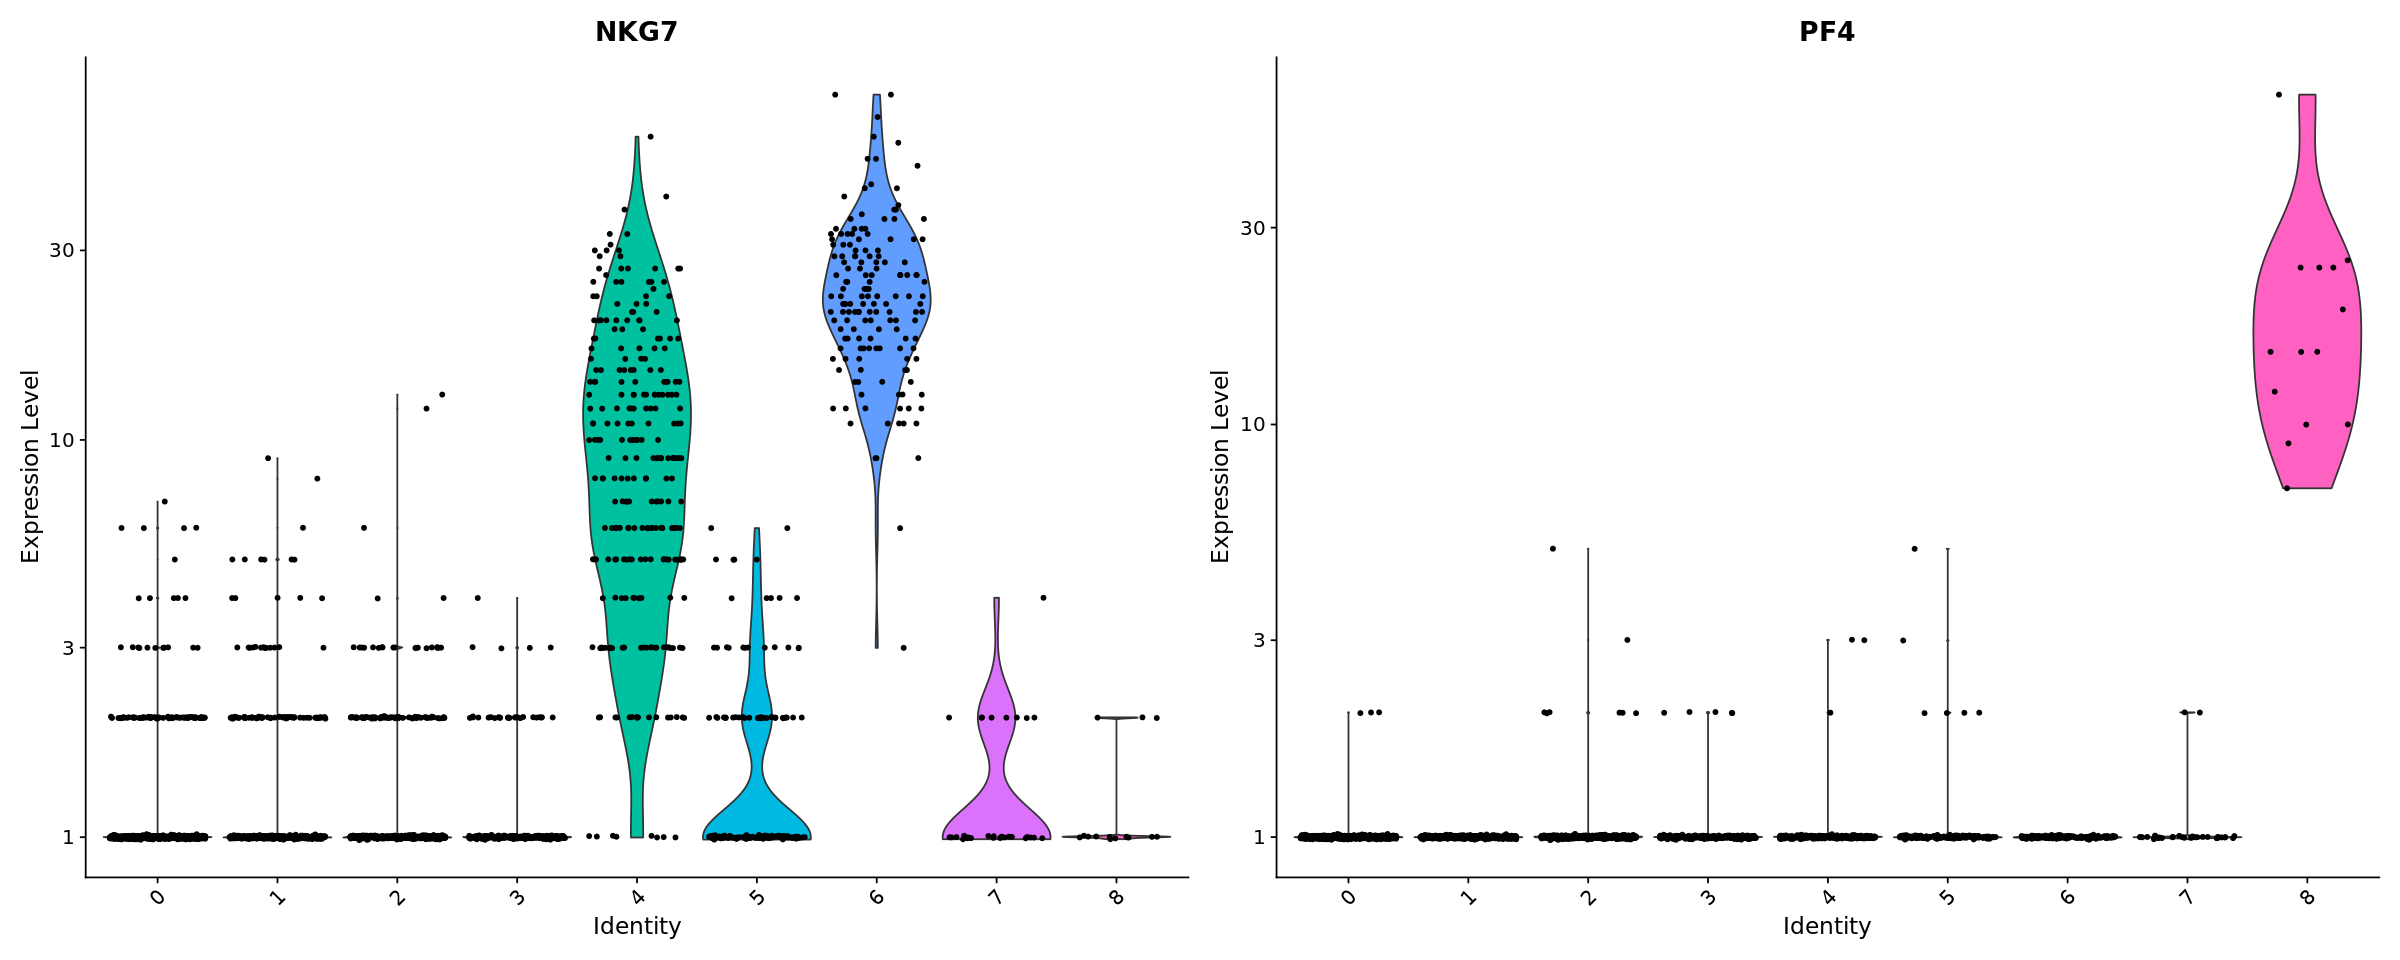

In [34]:
# you can plot raw counts as well
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

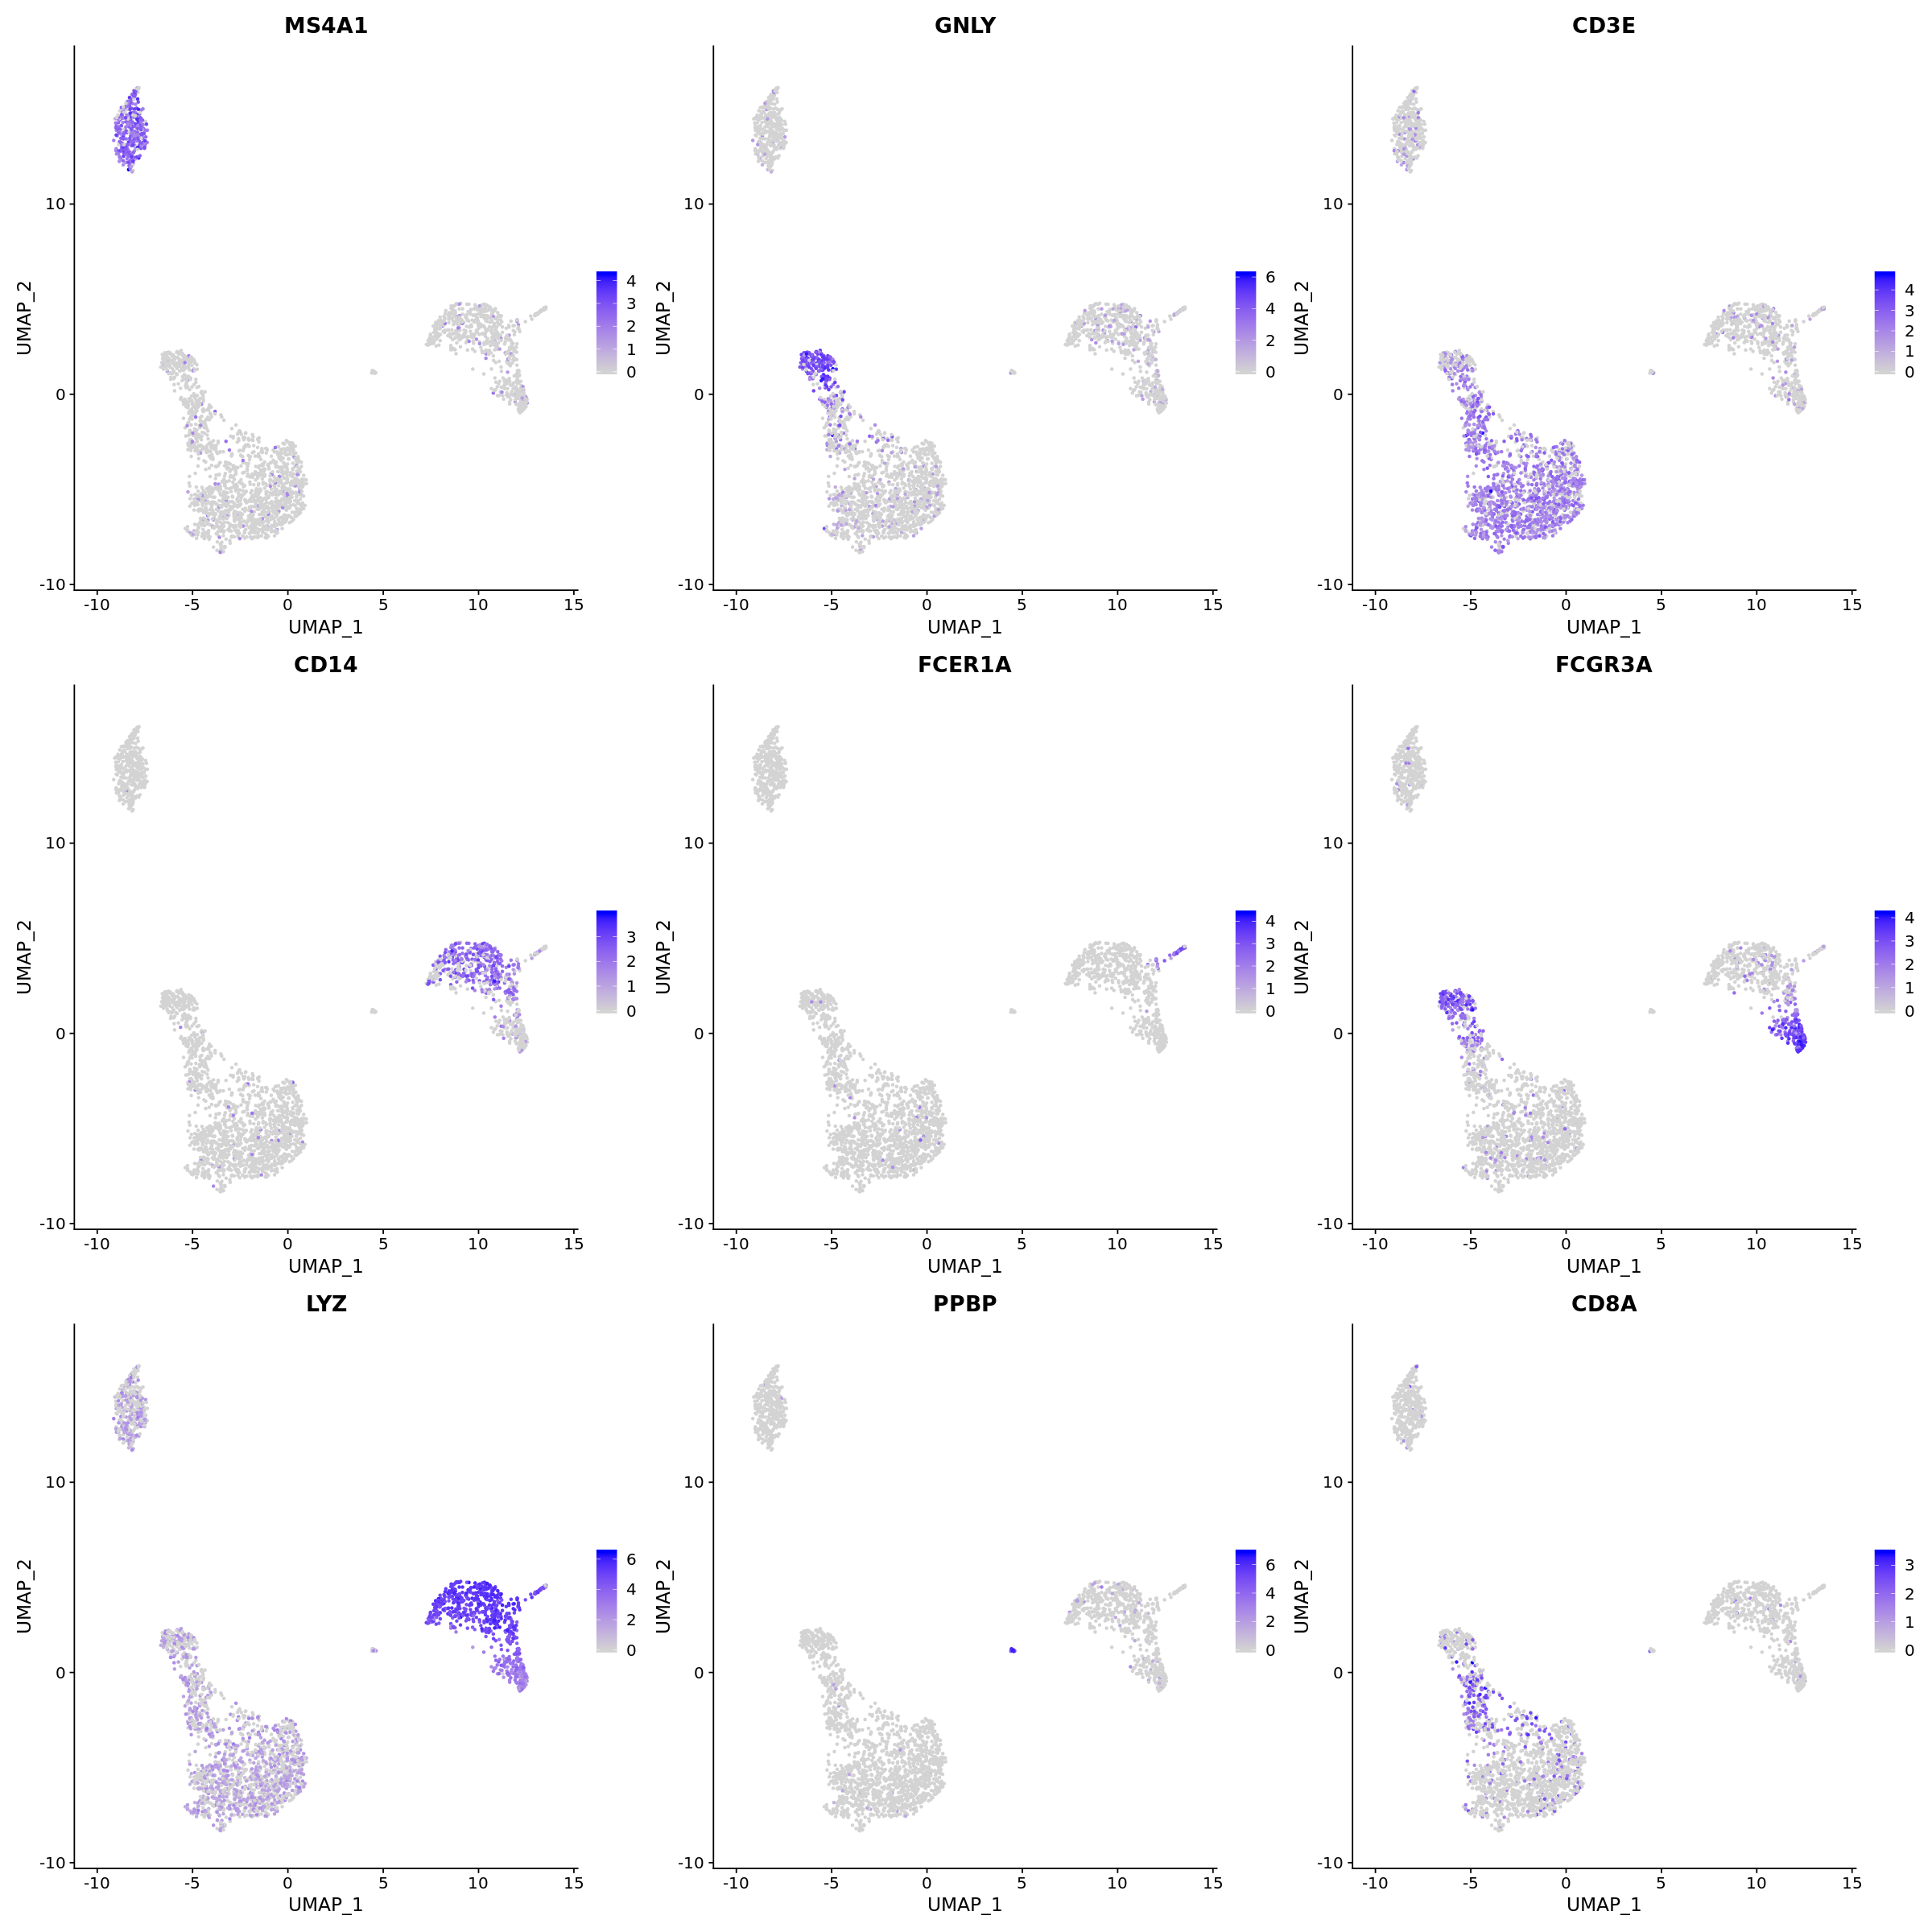

In [35]:
options(repr.plot.width=20, repr.plot.height=20)
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", 
    "CD8A"))

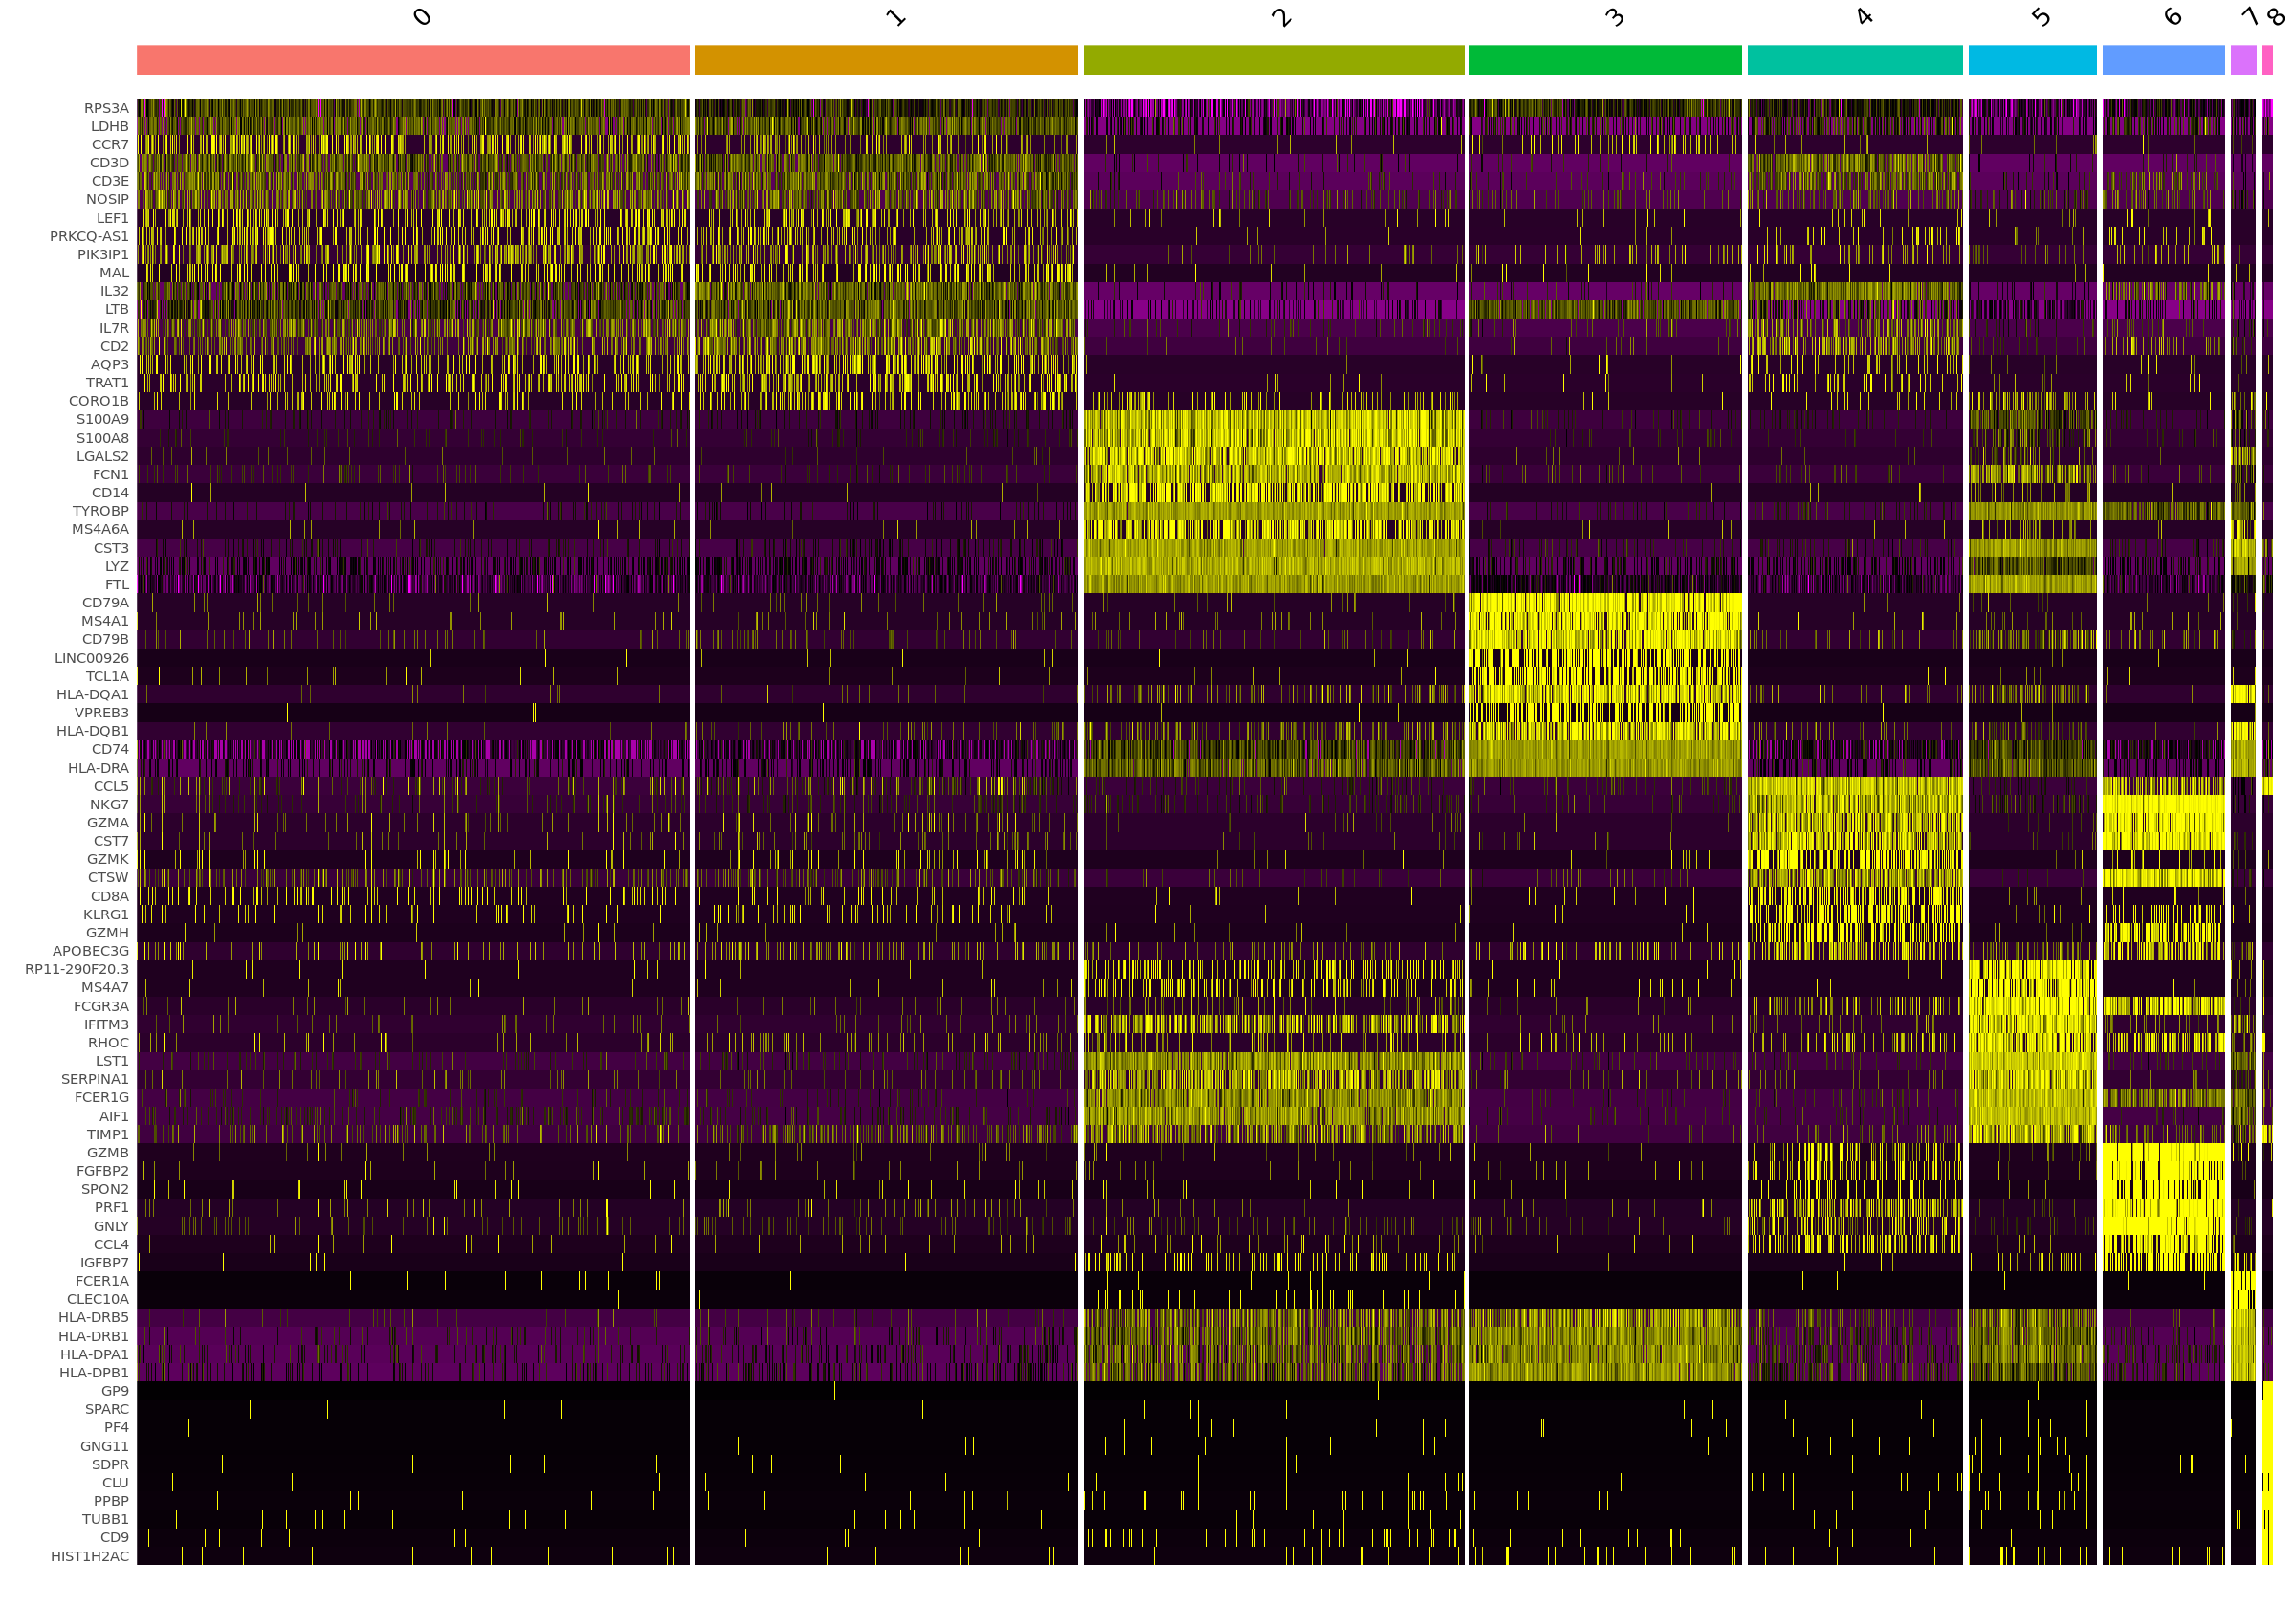

In [36]:
options(repr.plot.width=20, repr.plot.height=14)
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

## Assigning cell type identity to clusters

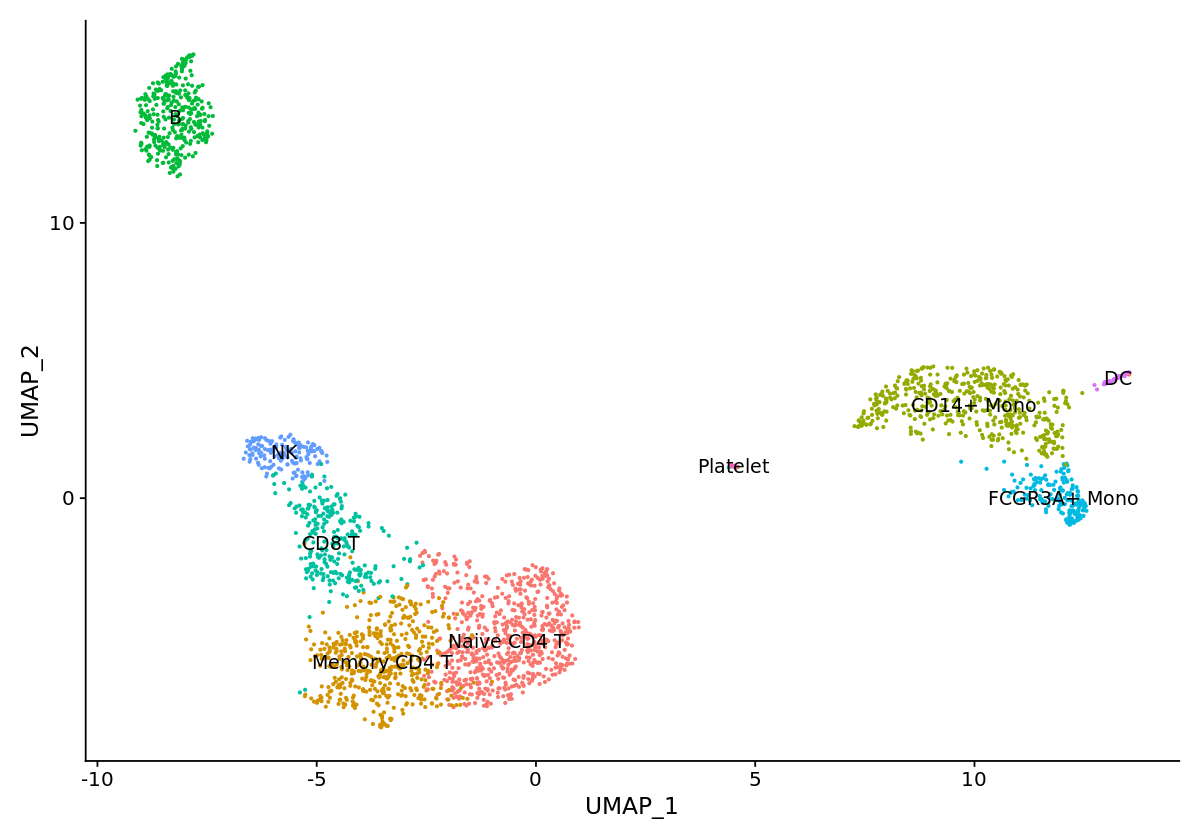

In [37]:
options(repr.plot.width=10, repr.plot.height=7)
new.cluster.ids <- c("Naive CD4 T", "Memory CD4 T", "CD14+ Mono", "B", "CD8 T", "FCGR3A+ Mono", 
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()